
# Hybrid ViT - U-Net For Building Segmentation From Satalite Imagery
### Draft Final Project Model V9
**By Irti Haq**

![alt text](<gandr-collage (2).jpg>)

**Research Questions:** Can a Hybrid ViT + U-Net model achieve high segmentation accuracy (Dice score) and low boundary error (HD95) when segmenting buildings from satellite imagery across diverse urban areas with varying geographic and urban/architectural characteristics?

**Dataset: Chinese GaoFen-7 (GF-7) satellite imagery** 

This dataset is a high-resolution building segmentation dataset. This GF-7 dataset provides an extensive coverage of urban and rural areas of China by picking 6 typical cities in China (Chen et al.2024). The dataset contains 5175 pairs of 512×512 image tiles and 170,015 buildings. Compared to other datasets constructed through satellite and aerial imagery, this dataset has various ground-truth labels for building extraction.

Link: [A benchmark GaoFen-7 dataset for building extraction from satellite images](https://doi.org/10.6084/m9.figshare.24305557)

**Model** : TransUNet

This model is a specialized adaptation of the TransUNet architecture, originally developed by Chen et al. (2021) for medical image segmentation. Here, its application has been applied for building segmentation from satellite imagery.

The Model is a Hybrid ViT + U-Net Model that uses a Vision Transformer as its Encoder and a U-Net Style Model as its Decoder. More specifically the model uses a CNN network (ResNet) and transformer blocks as the encoder and up sampling layers as the decoder to achieve the task. Inspired by a U-Net Structure, Trans-UNet uses the residual network to extract features and do down samplings. The results are then fed into a transformer to encode. Afterwards, up sampling is used to decode the information. The model uses a Pre trained Vision Transformer, specifically in this project, the [ResNet-50 Vit-B 16 ](https://github.com/google-research/vision_transformer) from Google Research's Vision Transformer implementation is used. 

Most of the Code and Architecture for the Model has been directly taken from the TransUNet project by Chen et al. (2021) and then adapted to be used for building Segmentation.  

##### **Source:** [TransUNet: Medical Image Segmentation](https://tianjinteda.github.io/Transunet.html)  & [TransUNet: Transformers Make Strong Encoders for Medical Image Segmentation](https://arxiv.org/pdf/2102.04306#page=5.23)


### Key Changes
Overall These are some of the Key Changes I have made to the models Architeture to improve perfomance for Building Segmentation from Satalite Imagery. 
1) The model optimizer was progressively changed from SGD with Momentum → Adam → AdamW → AdamW with AMSGrad. These changes significantly improved training speed, and adding AMSGrad in particular helped enhance convergence

2) The original use of polynomial learning rate decay led to inconsistent convergence behavior and slower training progress, particularly in the early epochs. To address this, I implemented CosineAnnealingWarmRestarts, which provided smoother and more adaptive learning rate scheduling. This change resulted in faster convergence, reduced training noise, and improved overall stability.

3) Introduced data augmentation using the Albumentations library. Initially applied a stronger set of transformations, but this led to worsened performance. The augmentations were then progressively simplified, ultimately leaving only mild geometric transforms (horizontal/vertical flips and 90° rotations) to improve model generalization and test performance.

4) Optimized various training parameters, including batch size, learning rate, number of skip connections, and number of training epochs.

In [1]:
# Loading necessary libraries
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import random
import h5py
import cv2
import numpy as np
import torch
from PIL import Image
from scipy import ndimage
from scipy.ndimage.interpolation import zoom
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

## Progress bar
from tqdm.notebook import tqdm

# Check for CUDA, then MPS (for Mac), then CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

C:\Users\irti2\AppData\Local\Temp\ipykernel_40076\2787216946.py:11: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import zoom


Using device: cuda


c:\Users\irti2\miniconda3\envs\pytorch\Lib\site-packages\albumentations\check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 11001] getaddrinfo failed>
  data = fetch_version_info()


In [2]:
def random_rot_flip(image, label):
    k = np.random.randint(0, 4)
    image = np.rot90(image, k)
    label = np.rot90(label, k)
    axis = np.random.randint(0, 2)
    image = np.flip(image, axis=axis).copy()
    label = np.flip(label, axis=axis).copy()
    return image, label


def random_rotate(image, label):
    angle = np.random.randint(-20, 20)
    image = ndimage.rotate(image, angle, order=0, reshape=False)
    label = ndimage.rotate(label, angle, order=0, reshape=False)
    return image, label

class RandomGenerator(object):
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        if random.random() > 0.5:
            image, label = random_rot_flip(image, label)
        elif random.random() > 0.5:
            image, label = random_rotate(image, label)
        x, y = image.shape
        if x != self.output_size[0] or y != self.output_size[1]:
            image = zoom(image, (self.output_size[0] / x, self.output_size[1] / y), order=3) 
            label = zoom(label, (self.output_size[0] / x, self.output_size[1] / y), order=0)
        image = torch.from_numpy(image.astype(np.float32)).unsqueeze(0)
        label = torch.from_numpy(label.astype(np.float32))
        sample = {'image': image, 'label': label.long()}
        return sample

### Data Loader Class

In [3]:
class GF7Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=224, transform=None):
        self.image_paths = sorted([
            os.path.join(image_dir, f) for f in os.listdir(image_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))
        ])
        self.mask_paths = sorted([
            os.path.join(mask_dir, f) for f in os.listdir(mask_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))
        ])
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Could not read image: {image_path}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
        image = cv2.resize(image, (self.image_size, self.image_size)) # Resize to target size
        image = image.astype(np.float32) / 255.0 # Normalize to [0, 1] 

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Could not read mask: {mask_path}")
        mask = cv2.resize(mask, (self.image_size, self.image_size)) # Resize to target size
        mask = (mask > 127).astype(np.float32)  # Binarize

        if self.transform:
            augmented = self.transform(image=image, mask=mask) 
            image = augmented['image'] 
            mask = augmented['mask']  # Already a tensor with shape [H, W] or [1, H, W]
        
        # If a transform is not provided, or if the probabilistic transform
        # was skipped, the data will still be numpy arrays.
        # This check ensures they are always converted to tensors.
        
        if not isinstance(image, torch.Tensor):
            # Apply ImageNet normalization and convert to a tensor
            image = (image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225]) # Standardize to ImageNet
            image = torch.from_numpy(image.transpose(2, 0, 1)).float() # Convert to [C, H, W]

        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).float()

        # Ensure mask has a channel dimension
        if mask.ndim == 2:
            mask = mask.unsqueeze(0)

        return image, mask

#### Testings to See if Dataloader is Working Correctly

In [4]:
# Test to see if the dataset works

from torch.utils.data import DataLoader

dataset = GF7Dataset(
    image_dir = "data/GF-7 Building (3Bands)/Train/image",
    mask_dir = "data/GF-7 Building (3Bands)/Train/label",
    image_size=224
)

loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Iterate over a batch
for images, masks in loader:
    print(images.shape)  # [B, 3, 224, 224]
    print(masks.shape)   # [B, 1, 224, 224]
    break

print(f"Number of samples in dataset: {len(dataset)}")

torch.Size([8, 3, 224, 224])
torch.Size([8, 1, 224, 224])
Number of samples in dataset: 3106


## Tranformations

#### Heavy Tranformation Pipeline

In [5]:
prob_pipeline = 1

tranform_pipline = A.Compose([
    
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    
    A.SomeOf([
        A.RandomBrightnessContrast(brightness_limit=[-0.2, 0.3], contrast_limit=0.2, p=1.0),
        A.RGBShift(r_shift_limit=8, g_shift_limit=8, b_shift_limit=8, p=1.0),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=1.0),
        A.RandomGamma(gamma_limit=(50, 110), p=0.8),
    ], n=2, p=0.77), # Fixed: n must be int
    
    
    # # Cloud Cover Simulation
    # A.SomeOf([
    #     A.RandomFog(fog_coef_range=(0.1, 0.2), alpha_coef=0.08, p=1.0),
    #     A.RandomShadow(p=1.0),
    # ], n=1, p=0.5),
    
    
    # Noise
    A.OneOf([
        A.MultiplicativeNoise(multiplier=(0.7, 1.2), per_channel=True,elementwise=True, p=1.0),
        # A.GaussNoise(p=1.0), Adding Too much noise
    ], p=0.4),
    
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=0.4), 
    #ToTensorV2(),
    
    ], p=prob_pipeline, seed=42)

#### Lite Transformation Pipeline

In [6]:
prob_pipeline = 1

lite_tranform_pipeline = A.Compose([
    
    # Light spatial transforms
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),  # Lower rotation probability

    # One mild color transform per sample
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=1.0),
        A.HueSaturationValue(hue_shift_limit=3, sat_shift_limit=5, val_shift_limit=3, p=1.0),
        A.RGBShift(r_shift_limit=3, g_shift_limit=3, b_shift_limit=3, p=1.0),
        A.RandomGamma(gamma_limit=(98, 102), p=1.0),
    ], p=0.3),  # Lighter color shift and reduced prob

    # Light noise
    A.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=True, elementwise=False, p=0.2),

    # Normalize + tensor
    #A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1.0),
    #ToTensorV2(p=1.0),
], p=prob_pipeline, seed=42)

#### XL Lite Transform Pipeline (Currently Used)

In [7]:
prob_pipeline = 1

XL_lite_tranform_pipeline = A.Compose([
    
    # Light spatial transforms
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),  # Lower rotation probability

    # # One mild color transform per sample
    # A.OneOf([
    #     A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=1.0),
    #     A.HueSaturationValue(hue_shift_limit=3, sat_shift_limit=5, val_shift_limit=3, p=1.0),
    #     A.RGBShift(r_shift_limit=3, g_shift_limit=3, b_shift_limit=3, p=1.0),
    #     A.RandomGamma(gamma_limit=(98, 102), p=1.0),
    # ], p=0.3),  # Lighter color shift and reduced prob

    # # Light noise
    # A.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=True, elementwise=False, p=0.2),

    # Normalize + tensor
    #A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1.0),
    #ToTensorV2(p=1.0),
], p=prob_pipeline, seed=42)

#### Testing and Checking Augmentations

In [8]:
# # Only Used to Check Augmentation
# dataset = GF7Dataset(
#     image_dir = "data/GF-7 Building (3Bands)/Train/image",
#     mask_dir = "data/GF-7 Building (3Bands)/Train/label",
#     image_size=224, 
#     transform=tranform_pipline
# )

# loader = DataLoader(dataset, batch_size=8, shuffle=True)

# # Iterate over a batch
# for images, masks in loader:
#     print(images.shape)  # [B, 3, 224, 224]
#     print(masks.shape)   # [B, 1, 224, 224]
#     break

# print(f"Number of samples in dataset: {len(dataset)}")

# import matplotlib.pyplot as plt
# import numpy as np

# # Get a batch from your loader
# for images, masks in loader:
#     for i in range(min(25, images.shape[0])):
#         img = images[i].cpu().numpy()
#         mask = masks[i].cpu().numpy().squeeze(0)
#         img = np.transpose(img, (1, 2, 0))

#         print(f"Original - min: {img.min():.4f}, max: {img.max():.4f}, mean: {img.mean():.4f}")
        
#         # More robust check for normalization
#         if abs(img.mean()) > 0.5 or img.min() < -0.1:  # Likely normalized
#             print("Detected normalized image, unnormalizing...")
#             mean = np.array([0.485, 0.456, 0.406])
#             std = np.array([0.229, 0.224, 0.225])
#             img = (img * std) + mean
#             print(f"After unnorm - min: {img.min():.4f}, max: {img.max():.4f}")
            
#         img = np.clip(img, 0, 1)
        
#         plt.figure(figsize=(6, 3))
#         plt.subplot(1, 2, 1)
#         plt.imshow(img)
#         plt.title("Image")
#         plt.axis('off')
#         plt.subplot(1, 2, 2)
#         plt.imshow(mask, cmap='gray')
#         plt.title("Mask")
#         plt.axis('off')
#         plt.show()
#     break

## ResNet

In [9]:
def get_r50_b16_config():
    """Returns the Resnet50 + ViT-B/16 configuration."""
    config = get_b16_config()
    config.patches.grid = (16, 16)
    config.resnet = ml_collections.ConfigDict()
    config.resnet.num_layers = (3, 4, 9)
    config.resnet.width_factor = 1

    config.classifier = 'seg'
    config.pretrained_path = '../model/ViT-B_16.npz'
    config.decoder_channels = (256, 128, 64, 16)
    config.skip_channels = [512, 256, 64, 16]
    config.n_classes = 2
    config.n_skip = 3
    config.activation = 'softmax'

    return config

In [10]:
from os.path import join as pjoin
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

def np2th(weights, conv=False):
    """Possibly convert HWIO to OIHW."""
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)

#standardize the weights before doing convolution
#weight -->(output_channel,input_channel,kernel_size[0],kernel_size[1])
#So compute mean and variance for each input_channel*kernel_size[0]*kernel_size[1]
class StdConv2d(nn.Conv2d):

    def forward(self, x):
        w = self.weight
        v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
        w = (w - m) / torch.sqrt(v + 1e-5)
        return F.conv2d(x, w, self.bias, self.stride, self.padding,
                        self.dilation, self.groups)

#do convolution using StdConv2d
def conv3x3(cin, cout, stride=1, groups=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=3, stride=stride,
                     padding=1, bias=bias, groups=groups)


def conv1x1(cin, cout, stride=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=1, stride=stride,
                     padding=0, bias=bias)

## Pre-Activation Bottleneck Block

In [11]:
class PreActBottleneck(nn.Module):
    """Pre-activation (v2) bottleneck block.
    """

    def __init__(self, cin, cout=None, cmid=None, stride=1):
        super().__init__()
        cout = cout or cin
        cmid = cmid or cout//4

        self.gn1 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv1 = conv1x1(cin, cmid, bias=False)
        self.gn2 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv2 = conv3x3(cmid, cmid, stride, bias=False)  # Original code has it on conv1!!
        self.gn3 = nn.GroupNorm(32, cout, eps=1e-6)
        self.conv3 = conv1x1(cmid, cout, bias=False)
        self.relu = nn.ReLU(inplace=True)

        if (stride != 1 or cin != cout):
            # Projection also with pre-activation according to paper.
            self.downsample = conv1x1(cin, cout, stride, bias=False)
            self.gn_proj = nn.GroupNorm(cout, cout)

    def forward(self, x):

        # Residual branch
        residual = x
        if hasattr(self, 'downsample'):
            residual = self.downsample(x)
            residual = self.gn_proj(residual)

        # Unit's branch
        y = self.relu(self.gn1(self.conv1(x)))
        y = self.relu(self.gn2(self.conv2(y)))
        y = self.gn3(self.conv3(y))

        y = self.relu(residual + y)
        return y

    def load_from(self, weights, n_block, n_unit):
        conv1_weight = np2th(weights[pjoin(n_block, n_unit, "conv1/kernel").replace('\\', '/')], conv=True)
        conv2_weight = np2th(weights[pjoin(n_block, n_unit, "conv2/kernel").replace('\\', '/')], conv=True)
        conv3_weight = np2th(weights[pjoin(n_block, n_unit, "conv3/kernel").replace('\\', '/')], conv=True)

        gn1_weight = np2th(weights[pjoin(n_block, n_unit, "gn1/scale").replace('\\', '/')])
        gn1_bias = np2th(weights[pjoin(n_block, n_unit, "gn1/bias").replace('\\', '/')])

        gn2_weight = np2th(weights[pjoin(n_block, n_unit, "gn2/scale").replace('\\', '/')])
        gn2_bias = np2th(weights[pjoin(n_block, n_unit, "gn2/bias").replace('\\', '/')])

        gn3_weight = np2th(weights[pjoin(n_block, n_unit, "gn3/scale").replace('\\', '/')])
        gn3_bias = np2th(weights[pjoin(n_block, n_unit, "gn3/bias").replace('\\', '/')])

        self.conv1.weight.copy_(conv1_weight)
        self.conv2.weight.copy_(conv2_weight)
        self.conv3.weight.copy_(conv3_weight)

        self.gn1.weight.copy_(gn1_weight.view(-1))
        self.gn1.bias.copy_(gn1_bias.view(-1))

        self.gn2.weight.copy_(gn2_weight.view(-1))
        self.gn2.bias.copy_(gn2_bias.view(-1))

        self.gn3.weight.copy_(gn3_weight.view(-1))
        self.gn3.bias.copy_(gn3_bias.view(-1))

        if hasattr(self, 'downsample'):
            proj_conv_weight = np2th(weights[pjoin(n_block, n_unit, "conv_proj/kernel").replace('\\', '/')], conv=True)
            proj_gn_weight = np2th(weights[pjoin(n_block, n_unit, "gn_proj/scale").replace('\\', '/')])
            proj_gn_bias = np2th(weights[pjoin(n_block, n_unit, "gn_proj/bias").replace('\\', '/')])

            self.downsample.weight.copy_(proj_conv_weight)
            self.gn_proj.weight.copy_(proj_gn_weight.view(-1))
            self.gn_proj.bias.copy_(proj_gn_bias.view(-1))

### Resnet V2

In [12]:
class ResNetV2(nn.Module):
    """Implementation of Pre-activation (v2) ResNet mode."""

    def __init__(self, block_units, width_factor):
        super().__init__()
        width = int(64 * width_factor)
        self.width = width

        self.root = nn.Sequential(OrderedDict([
            ('conv', StdConv2d(3, width, kernel_size=7, stride=2, bias=False, padding=3)),
            ('gn', nn.GroupNorm(32, width, eps=1e-6)),
            ('relu', nn.ReLU(inplace=True)),
            # ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0))
        ]))

        self.body = nn.Sequential(OrderedDict([
            ('block1', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width, cout=width*4, cmid=width))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*4, cout=width*4, cmid=width)) for i in range(2, block_units[0] + 1)],
                ))),
            ('block2', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width*4, cout=width*8, cmid=width*2, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*8, cout=width*8, cmid=width*2)) for i in range(2, block_units[1] + 1)],
                ))),
            ('block3', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width*8, cout=width*16, cmid=width*4, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*16, cout=width*16, cmid=width*4)) for i in range(2, block_units[2] + 1)],
                ))),
        ]))
    
    def forward(self, x):
        features = []
        b, c, in_size, _ = x.size()
        x = self.root(x)
        features.append(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)(x)
        for i in range(len(self.body)-1):
            #According to paper, you have to concatenate the the output of resnet 
            #blocks with decoder part so you have to make sure that the height and 
            #width matches
            x = self.body[i](x)
            right_size = int(in_size / 4 / (i+1))
            if x.size()[2] != right_size:
                pad = right_size - x.size()[2]
                assert pad < 3 and pad > 0, "x {} should {}".format(x.size(), right_size)
                feat = torch.zeros((b, x.size()[1], right_size, right_size), device=x.device)
                feat[:, :, 0:x.size()[2], 0:x.size()[3]] = x[:]
            else:
                feat = x
            features.append(feat)
        x = self.body[-1](x)
        return x, features[::-1]

In [13]:
# coding=utf-8
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import copy
import logging
import math
import ml_collections
from os.path import join as pjoin

import torch
import torch.nn as nn
import numpy as np

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torch.nn.modules.utils import _pair
from scipy import ndimage
logger = logging.getLogger(__name__)
def get_b16_config():
    """Returns the ViT-B/16 configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 768
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 3072
    config.transformer.num_heads = 12
    config.transformer.num_layers = 12
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1

    config.classifier = 'seg'
    config.representation_size = None
    config.resnet_pretrained_path = None
    config.pretrained_path = '../model/vit_checkpoint/imagenet21k/ViT-B_16.npz'
    config.patch_size = 16

    config.decoder_channels = (256, 128, 64, 16)
    config.n_classes = 2
    config.activation = 'softmax'
    return config

def get_r50_b16_config():
    """Returns the Resnet50 + ViT-B/16 configuration."""
    config = get_b16_config()
    config.patches.grid = (16, 16)
    config.resnet = ml_collections.ConfigDict()
    config.resnet.num_layers = (3, 4, 9)
    config.resnet.width_factor = 1

    config.classifier = 'seg'
    config.pretrained_path = '../model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz'
    config.decoder_channels = (256, 128, 64, 16)
    config.skip_channels = [512, 256, 64, 16]
    config.n_classes = 2
    config.n_skip = 3
    config.activation = 'softmax'

    return config
CONFIGS = {
    'ViT-B_16': get_b16_config(),
    'R50-ViT-B_16': get_r50_b16_config(),

}

## Vision Transformer (ViT)

### Embeding Layer

In [14]:
class Embeddings(nn.Module):
    """Construct the embeddings from patch, position embeddings.
    """
    def __init__(self, config, img_size, in_channels=3):
        super(Embeddings, self).__init__()
        self.hybrid = None
        self.config = config
        img_size = _pair(img_size)
        #print(config.patches.get("grid"))
        #print(img_size)
        if config.patches.get("grid") is not None:   # ResNet
            grid_size = config.patches["grid"]
            #print(grid_size)
            patch_size = (img_size[0] // 16 // grid_size[0], img_size[1] // 16 // grid_size[1])
            patch_size_real = (patch_size[0] * 16, patch_size[1] * 16)
            #print(patch_size,patch_size_real)
            n_patches = (img_size[0] // patch_size_real[0]) * (img_size[1] // patch_size_real[1])  
            
            self.hybrid = True
        else:
            patch_size = _pair(config.patches["size"])
            n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
            self.hybrid = False

        if self.hybrid:
            self.hybrid_model = ResNetV2(block_units=config.resnet.num_layers, width_factor=config.resnet.width_factor)
            in_channels = self.hybrid_model.width * 16
        self.patch_embeddings = Conv2d(in_channels=in_channels,
                                       out_channels=config.hidden_size,
                                       kernel_size=patch_size,
                                       stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches, config.hidden_size))

        self.dropout = Dropout(config.transformer["dropout_rate"])


    def forward(self, x):
        if self.hybrid:
            x, features = self.hybrid_model(x)
        else:
            features = None
        x = self.patch_embeddings(x)  # (B, hidden. n_patches^(1/2), n_patches^(1/2))
        x = x.flatten(2)
        x = x.transpose(-1, -2)  # (B, n_patches, hidden)

        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings, features

### Attention

In [15]:
ATTENTION_Q = "MultiHeadDotProductAttention_1/query"
ATTENTION_K = "MultiHeadDotProductAttention_1/key"
ATTENTION_V = "MultiHeadDotProductAttention_1/value"
ATTENTION_OUT = "MultiHeadDotProductAttention_1/out"
FC_0 = "MlpBlock_3/Dense_0"
FC_1 = "MlpBlock_3/Dense_1"
ATTENTION_NORM = "LayerNorm_0"
MLP_NORM = "LayerNorm_2"


def np2th(weights, conv=False):
    """Possibly convert HWIO to OIHW."""
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)


def swish(x):
    return x * torch.sigmoid(x)


ACT2FN = {"gelu": torch.nn.functional.gelu, "relu": torch.nn.functional.relu, "swish": swish}


class Attention(nn.Module):
    def __init__(self, config, vis):
        super(Attention, self).__init__()
        self.vis = vis
        self.num_attention_heads = config.transformer["num_heads"]
        self.attention_head_size = int(config.hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = Linear(config.hidden_size, self.all_head_size)
        self.key = Linear(config.hidden_size, self.all_head_size)
        self.value = Linear(config.hidden_size, self.all_head_size)

        self.out = Linear(config.hidden_size, config.hidden_size)
        self.attn_dropout = Dropout(config.transformer["attention_dropout_rate"])
        self.proj_dropout = Dropout(config.transformer["attention_dropout_rate"])

        self.softmax = Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights

### Multilayer Perceptron

In [16]:
class Mlp(nn.Module):
    def __init__(self, config):
        super(Mlp, self).__init__()
        self.fc1 = Linear(config.hidden_size, config.transformer["mlp_dim"])
        self.fc2 = Linear(config.transformer["mlp_dim"], config.hidden_size)
        self.act_fn = ACT2FN["gelu"]
        self.dropout = Dropout(config.transformer["dropout_rate"])

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

### Transformer block 

In [17]:
class Block(nn.Module):
    def __init__(self, config, vis):
        super(Block, self).__init__()
        self.hidden_size = config.hidden_size
        self.attention_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn = Mlp(config)
        self.attn = Attention(config, vis)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h

        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x, weights

    def load_from(self, weights, n_block):
        ROOT = f"Transformer/encoderblock_{n_block}"
        with torch.no_grad():
            Temp=weights
            query_weight = np2th(weights[pjoin(ROOT,ATTENTION_Q,"kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()

            key_weight = np2th(weights[pjoin(ROOT, ATTENTION_K, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()
            value_weight = np2th(weights[pjoin(ROOT, ATTENTION_V, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()
            out_weight = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()

            query_bias = np2th(weights[pjoin(ROOT, ATTENTION_Q, "bias").replace('\\', '/')]).view(-1)
            key_bias = np2th(weights[pjoin(ROOT, ATTENTION_K, "bias").replace('\\', '/')]).view(-1)
            value_bias = np2th(weights[pjoin(ROOT, ATTENTION_V, "bias").replace('\\', '/')]).view(-1)
            out_bias = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "bias").replace('\\', '/')]).view(-1)

            self.attn.query.weight.copy_(query_weight)
            self.attn.key.weight.copy_(key_weight)
            self.attn.value.weight.copy_(value_weight)
            self.attn.out.weight.copy_(out_weight)
            self.attn.query.bias.copy_(query_bias)
            self.attn.key.bias.copy_(key_bias)
            self.attn.value.bias.copy_(value_bias)
            self.attn.out.bias.copy_(out_bias)

            mlp_weight_0 = np2th(weights[pjoin(ROOT, FC_0, "kernel").replace('\\', '/')]).t()
            mlp_weight_1 = np2th(weights[pjoin(ROOT, FC_1, "kernel").replace('\\', '/')]).t()
            mlp_bias_0 = np2th(weights[pjoin(ROOT, FC_0, "bias").replace('\\', '/')]).t()
            mlp_bias_1 = np2th(weights[pjoin(ROOT, FC_1, "bias").replace('\\', '/')]).t()

            self.ffn.fc1.weight.copy_(mlp_weight_0)
            self.ffn.fc2.weight.copy_(mlp_weight_1)
            self.ffn.fc1.bias.copy_(mlp_bias_0)
            self.ffn.fc2.bias.copy_(mlp_bias_1)

            self.attention_norm.weight.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "scale").replace('\\', '/')]))
            self.attention_norm.bias.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "bias").replace('\\', '/')]))
            self.ffn_norm.weight.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "scale").replace('\\', '/')]))
            self.ffn_norm.bias.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "bias").replace('\\', '/')]))

### Encoder

In [18]:
class Encoder(nn.Module):
    def __init__(self, config, vis):
        super(Encoder, self).__init__()
        self.vis = vis
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config.hidden_size, eps=1e-6)
        for _ in range(config.transformer["num_layers"]):
            layer = Block(config, vis)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):


        attn_weights = []
        for layer_block in self.layer:
            hidden_states, weights = layer_block(hidden_states)
            if self.vis:
                attn_weights.append(weights)
        encoded = self.encoder_norm(hidden_states)
        return encoded, attn_weights

### Transformer

In [19]:
class Transformer(nn.Module):
    def __init__(self, config, img_size, vis):
        super(Transformer, self).__init__()
        self.embeddings = Embeddings(config, img_size=img_size)
        self.encoder = Encoder(config, vis)

    def forward(self, input_ids):
        embedding_output, features = self.embeddings(input_ids)
        encoded, attn_weights = self.encoder(embedding_output)  # (B, n_patch, hidden)
        return encoded, attn_weights, features

## Decoder 

In [20]:
class Conv2dReLU(nn.Sequential):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            padding=0,
            stride=1,
            use_batchnorm=True,
    ):
        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=not (use_batchnorm),
        )
        relu = nn.ReLU(inplace=True)

        bn = nn.BatchNorm2d(out_channels)

        super(Conv2dReLU, self).__init__(conv, bn, relu)

In [21]:
class DecoderBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            skip_channels=0,
            use_batchnorm=True,
    ):
        super().__init__()
        self.conv1 = Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, x, skip=None):
        x = self.up(x)
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [22]:
class DecoderCup(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        head_channels = 512
        self.conv_more = Conv2dReLU(
            config.hidden_size,
            head_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=True,
        )
        decoder_channels = config.decoder_channels
        in_channels = [head_channels] + list(decoder_channels[:-1])
        out_channels = decoder_channels

        if self.config.n_skip != 0:
            skip_channels = self.config.skip_channels
            for i in range(4-self.config.n_skip):  # re-select the skip channels according to n_skip
                skip_channels[3-i]=0

        else:
            skip_channels=[0,0,0,0]

        blocks = [
            DecoderBlock(in_ch, out_ch, sk_ch) for in_ch, out_ch, sk_ch in zip(in_channels, out_channels, skip_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, hidden_states, features=None):
        B, n_patch, hidden = hidden_states.size()  # reshape from (B, n_patch, hidden) to (B, h, w, hidden)
        h, w = int(np.sqrt(n_patch)), int(np.sqrt(n_patch))
        x = hidden_states.permute(0, 2, 1)
        x = x.contiguous().view(B, hidden, h, w)
        x = self.conv_more(x)
        for i, decoder_block in enumerate(self.blocks):
            if features is not None:
                skip = features[i] if (i < self.config.n_skip) else None
            else:
                skip = None
            x = decoder_block(x, skip=skip)
        return x

### Segmentation Head

In [23]:
class SegmentationHead(nn.Sequential):

    def __init__(self, in_channels, out_channels, kernel_size=3, upsampling=1):
        conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        upsampling = nn.UpsamplingBilinear2d(scale_factor=upsampling) if upsampling > 1 else nn.Identity()
        super().__init__(conv2d, upsampling)

## Vision Tranformer Class

In [24]:
class VisionTransformer(nn.Module):
    def __init__(self, config, img_size=224, num_classes=21843, zero_head=False, vis=False):
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.classifier = config.classifier
        self.transformer = Transformer(config, img_size, vis)
        self.decoder = DecoderCup(config)
        self.segmentation_head = SegmentationHead(
            in_channels=config['decoder_channels'][-1],
            out_channels=config['n_classes'],
            kernel_size=3,
        )
        self.config = config

    def forward(self, x):
        if x.size()[1] == 1:
            x = x.repeat(1,3,1,1)
        x, attn_weights, features = self.transformer(x)  # (B, n_patch, hidden)
        x = self.decoder(x, features)
        logits = self.segmentation_head(x)
        return logits

    def load_from(self, weights):
        with torch.no_grad():

            res_weight = weights
            self.transformer.embeddings.patch_embeddings.weight.copy_(np2th(weights["embedding/kernel"], conv=True))
            self.transformer.embeddings.patch_embeddings.bias.copy_(np2th(weights["embedding/bias"]))

            self.transformer.encoder.encoder_norm.weight.copy_(np2th(weights["Transformer/encoder_norm/scale"]))
            self.transformer.encoder.encoder_norm.bias.copy_(np2th(weights["Transformer/encoder_norm/bias"]))

            posemb = np2th(weights["Transformer/posembed_input/pos_embedding"])

            posemb_new = self.transformer.embeddings.position_embeddings
            if posemb.size() == posemb_new.size():
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            elif posemb.size()[1]-1 == posemb_new.size()[1]:
                posemb = posemb[:, 1:]
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            else:
                logger.info("load_pretrained: resized variant: %s to %s" % (posemb.size(), posemb_new.size()))
                ntok_new = posemb_new.size(1)
                if self.classifier == "seg":
                    _, posemb_grid = posemb[:, :1], posemb[0, 1:]
                gs_old = int(np.sqrt(len(posemb_grid)))
                gs_new = int(np.sqrt(ntok_new))
                print('load_pretrained: grid-size from %s to %s' % (gs_old, gs_new))
                posemb_grid = posemb_grid.reshape(gs_old, gs_old, -1)
                zoom = (gs_new / gs_old, gs_new / gs_old, 1)
                posemb_grid = ndimage.zoom(posemb_grid, zoom, order=1)  # th2np
                posemb_grid = posemb_grid.reshape(1, gs_new * gs_new, -1)
                posemb = posemb_grid
                self.transformer.embeddings.position_embeddings.copy_(np2th(posemb))

            # Encoder whole
            for bname, block in self.transformer.encoder.named_children():
                for uname, unit in block.named_children():
                    unit.load_from(weights, n_block=uname)

            if self.transformer.embeddings.hybrid:
                self.transformer.embeddings.hybrid_model.root.conv.weight.copy_(np2th(res_weight["conv_root/kernel"], conv=True))
                gn_weight = np2th(res_weight["gn_root/scale"]).view(-1)
                gn_bias = np2th(res_weight["gn_root/bias"]).view(-1)
                self.transformer.embeddings.hybrid_model.root.gn.weight.copy_(gn_weight)
                self.transformer.embeddings.hybrid_model.root.gn.bias.copy_(gn_bias)

                for bname, block in self.transformer.embeddings.hybrid_model.body.named_children():
                    for uname, unit in block.named_children():
                        unit.load_from(res_weight, n_block=bname, n_unit=uname)

## Loss Function

In [25]:
class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i  # * torch.ones_like(input_tensor)
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - loss
        return loss

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes
        assert inputs.size() == target.size(), 'predict {} & target {} shape do not match'.format(inputs.size(), target.size())
        class_wise_dice = []
        loss = 0.0
        for i in range(0, self.n_classes):
            dice = self._dice_loss(inputs[:, i], target[:, i])
            class_wise_dice.append(1.0 - dice.item())
            loss += dice * weight[i]
        return loss / self.n_classes

## Training

In [26]:
# Libaries Used for Training
import argparse
import logging
import os
import random
import sys
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tensorboardX import SummaryWriter
from torch.nn.modules.loss import CrossEntropyLoss
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from tqdm import tqdm
from torchvision import transforms

import time
from tqdm.notebook import tqdm 


### Trainer

In [27]:
def trainer_synapse(args, model, snapshot_path):

    logging.basicConfig(filename=snapshot_path + "/log.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
    logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
    logging.info(str(args))

    base_lr = args.base_lr
    num_classes = args.num_classes
    batch_size = args.batch_size * args.n_gpu

    # Use GF7Dataset
    db_train = GF7Dataset(
        image_dir=args.image_dir,
        mask_dir=args.mask_dir,
        image_size=args.img_size,
        transform= tranform_pipline   # Add Albumentations if needed
    )

    print("The length of train set is: {}".format(len(db_train)))

    def worker_init_fn(worker_id):
        random.seed(args.seed + worker_id)

    trainloader = DataLoader(
        db_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
        worker_init_fn=worker_init_fn
    )

    if args.n_gpu > 1:
        model = nn.DataParallel(model)

    model.train()
    ce_loss = CrossEntropyLoss()
    dice_loss = DiceLoss(num_classes)
    optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=0.0001, amsgrad=True) # Changed to AdamW (Adam decreased training time by almost 50%) added Armsgrad
    
    max_epoch = args.max_epochs
    max_iterations = max_epoch * len(trainloader)
    
    # Num restarts over full training
    num_restarts = 3
    
    # Compute adaptive T_0 based on total iterations
    T_0 = max_iterations // num_restarts
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=T_0,
        T_mult=1,           # keep restarts evenly spaced
        eta_min=1e-6        # stable minimum learning rate for Adam
    )
        
    writer = SummaryWriter(snapshot_path + '/log')

    iter_num = 0
    logging.info("{} iterations per epoch. {} max iterations ".format(len(trainloader), max_iterations))

    start_time = time.time()
    
    total_loss_sum = 0.0
    total_loss_count = 0
    
    conditional_saves_count = 0
    max_conditional_saves = 15
    
    iterator = tqdm(range(max_epoch), ncols=500, desc="Epoch", leave=False)  # leave=False to avoid cluttering the output
    for epoch_num in iterator:
        for i_batch, (image_batch, label_batch) in enumerate(trainloader):  # Tuple unpacking
            image_batch, label_batch = image_batch.cuda(), label_batch.cuda()

            outputs = model(image_batch)
            loss_ce = ce_loss(outputs, label_batch.long().squeeze(1))  # squeeze if shape is [B, 1, H, W]
            loss_dice = dice_loss(outputs, label_batch.squeeze(1), softmax=True)
            loss = 0.5 * loss_ce + 0.5 * loss_dice

            if iter_num > max_iterations - 10:
                total_loss_sum += loss.item()
                total_loss_count += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Step the scheduler (use epoch + batch/len(trainloader) for smooth schedule)
            scheduler.step(epoch_num + i_batch / len(trainloader))

            # Retired learning rate decay, now using 
            #lr_ = base_lr * (1.0 - iter_num / max_iterations) ** 0.9 # Polynomial decay of Learning Rate, leftover from original code with SGD however still works with AdamW, sure that every update step doesn't exceed lambda 
             
            # for param_group in optimizer.param_groups:
            #     param_group['lr'] = lr_

            iter_num += 1
            current_lr = optimizer.param_groups[0]['lr']
            writer.add_scalar('info/lr', current_lr, iter_num)
            writer.add_scalar('info/total_loss', loss, iter_num)
            writer.add_scalar('info/loss_ce', loss_ce, iter_num)

            #logging.info('iteration %d : loss : %f, loss_ce: %f' % (iter_num, loss.item(), loss_ce.item()))

            # Optionally, only log every N iterations
            if iter_num % 10 == 0:
                logging.info('iteration %d : loss : %f, loss_ce: %f' % (iter_num, loss.item(), loss_ce.item()))
                
            if iter_num > max_iterations - 10:
                logging.info('iteration %d : loss : %f, loss_ce: %f' % (iter_num, loss.item(), loss_ce.item()))

            if iter_num % 20 == 0:
                image = image_batch[1, 0:1, :, :]
                image = (image - image.min()) / (image.max() - image.min())
                writer.add_image('train/Image', image, iter_num)
                outputs_vis = torch.argmax(torch.softmax(outputs, dim=1), dim=1, keepdim=True)
                writer.add_image('train/Prediction', outputs_vis[1, ...] * 50, iter_num)
                labs = label_batch[1, ...] * 50  # Remove .unsqueeze(0)
                writer.add_image('train/GroundTruth', labs, iter_num)

        save_interval = 50
        if epoch_num > int(max_epoch / 2) and (epoch_num + 1) % save_interval == 0:
            save_mode_path = os.path.join(snapshot_path, f'epoch_{epoch_num}.pth')
            torch.save(model.state_dict(), save_mode_path)
            logging.info(f"save model to {save_mode_path}")

        save_interval_2 = 5 # Changes back To 10 After
        if epoch_num > 88 and (epoch_num + 1) % save_interval_2 == 0:
            save_mode_path = os.path.join(snapshot_path, f'epoch_{epoch_num}_iter_{iter_num}.pth')
            torch.save(model.state_dict(), save_mode_path)
            logging.info(f"save model to {save_mode_path}")
            
        # If CE Loss Less Than 0.06 Save Model (Limited to 5 saves)
        try:
            if loss_ce.item() < 0.06 and conditional_saves_count < max_conditional_saves:
                save_mode_path = os.path.join(snapshot_path, f'LOW_CE_epoch_{epoch_num}_iter_{iter_num}_loss_{loss_ce.item():.4f}.pth')
                torch.save(model.state_dict(), save_mode_path)
                logging.info(f"save model to {save_mode_path} with loss {loss_ce.item():.4f}")
                conditional_saves_count += 1
                logging.info(f"Conditional saves: {conditional_saves_count}/{max_conditional_saves}")
        except Exception as e:
            logging.warning(f"Failed to save model at epoch {epoch_num}, iter {iter_num}: {e}")
            # Continue training without interruption
            

        if epoch_num >= max_epoch - 1:
            save_mode_path = os.path.join(snapshot_path, f'epoch_{epoch_num}.pth')
            torch.save(model.state_dict(), save_mode_path)
            logging.info(f"save model to {save_mode_path}")
            iterator.close()
            break

    writer.close()
    
     # Calculate and print total time and average seconds per iteration
    total_time = time.time() - start_time
    avg_time_per_iter = total_time / iter_num if iter_num > 0 else 0
    avg_loss = total_loss_sum / total_loss_count if total_loss_count > 0 else 0

    print("------Training Stats------")
    print(f"Training finished in {total_time:.2f} seconds ({total_time/60:.2f} minutes).")
    print(f"Average time per iteration: {avg_time_per_iter:.2f}s/it")
    print(f"Average loss: {avg_loss:.4f}")

    return "Training Finished!"


### Training Arguments

In [28]:
import argparse

parser = argparse.ArgumentParser()

# Original args (unchanged)
parser.add_argument('--dataset', type=str, default='GF7')
parser.add_argument('--num_classes', type=int, default=2)
parser.add_argument('--max_iterations', type=int, default=30000)
parser.add_argument('--max_epochs', type=int, default=8)
parser.add_argument('--batch_size', type=int, default=8)
parser.add_argument('--n_gpu', type=int, default=1)
parser.add_argument('--deterministic', type=int, default=1) # Make it 1 for reproducibility
parser.add_argument('--base_lr', type=float, default=0.001)
parser.add_argument('--img_size', type=int, default=224)
parser.add_argument('--seed', type=int, default=42)
parser.add_argument('--n_skip', type=int, default=3)
parser.add_argument('--vit_name', type=str, default='R50-ViT-B_16')
parser.add_argument('--vit_patches_size', type=int, default=16)

# Add these two for GF7Dataset
parser.add_argument('--image_dir', type=str, help='Path to satellite images')
parser.add_argument('--mask_dir', type=str, help='Path to segmentation masks')

# set Epochs common variable and convert to string
epc = '205'

# Parse args manually for notebook
args = parser.parse_args(args=[
    '--dataset', 'GF7',
    '--num_classes', '2',
    '--max_epochs', epc, # Should be 20 = 30 min and 50 = 1 hour
    '--batch_size', '25', # This Was Optized for my Computer & Was changed From 20 to 25 
    '--n_gpu', '1',
    '--base_lr', '0.0001', # Changed from 0.001 to 0.0001 for better stability 
    '--img_size', '224',
    '--seed', '42',
    '--n_skip', '3',
    '--vit_name', 'R50-ViT-B_16',
    '--vit_patches_size', '16',
    '--image_dir', 'data/GF-7 Building (3Bands)/Train/image', # Change this Back    
    '--mask_dir', 'data/GF-7 Building (3Bands)/Train/label' # Change This Back
])

print(args)

Namespace(dataset='GF7', num_classes=2, max_iterations=30000, max_epochs=205, batch_size=25, n_gpu=1, deterministic=1, base_lr=0.0001, img_size=224, seed=42, n_skip=3, vit_name='R50-ViT-B_16', vit_patches_size=16, image_dir='data/GF-7 Building (3Bands)/Train/image', mask_dir='data/GF-7 Building (3Bands)/Train/label')


In [29]:
# -----------------------
# Environment Setup
# -----------------------
import os
import random
import numpy as np
import torch
from torch.backends import cudnn

if not args.deterministic:
    cudnn.benchmark = True
    cudnn.deterministic = False
else:
    cudnn.benchmark = False
    cudnn.deterministic = True

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)

# -----------------------
# Dataset Configuration
# -----------------------
dataset_name = 'GF7'
dataset_config = {
    'GF7': {
        'image_dir': args.image_dir,
        'mask_dir': args.mask_dir,
        'num_classes': 2
    }
}

if args.batch_size != 24 and args.batch_size % 6 == 0:
    args.base_lr *= args.batch_size / 24

args.dataset = dataset_name
args.num_classes = dataset_config[dataset_name]['num_classes']
args.image_dir = dataset_config[dataset_name]['image_dir']
args.mask_dir = dataset_config[dataset_name]['mask_dir']
args.is_pretrain = True

# -----------------------
# Snapshot Path
# -----------------------
args.exp = f'TU_{dataset_name}{args.img_size}'
snapshot_path = f"model/{args.exp}/TU"
snapshot_path += '_pretrain' if args.is_pretrain else ''
snapshot_path += f"_{args.vit_name}_skip{args.n_skip}"
if args.vit_patches_size != 16:
    snapshot_path += f"_vitpatch{args.vit_patches_size}"
if args.max_iterations != 30000:
    snapshot_path += f"_{str(args.max_iterations)[:2]}k"
if args.max_epochs != 30:
    snapshot_path += f"_epo{args.max_epochs}"
snapshot_path += f"_bs{args.batch_size}"
if args.base_lr != 0.01:
    snapshot_path += f"_lr{args.base_lr}"
snapshot_path += f"_{args.img_size}"
if args.seed != 1234:
    snapshot_path += f"_s{args.seed}"

# Create snapshot directory
if not os.path.exists(snapshot_path):
    os.makedirs(snapshot_path)

# -----------------------
# ViT Config and Model
# -----------------------
#Assumes CONFIGS and VisionTransformer were already defined in earlier cells
config_vit = CONFIGS[args.vit_name]
config_vit.n_classes = args.num_classes
config_vit.n_skip = args.n_skip
config_vit.patches.size = (args.vit_patches_size, args.vit_patches_size)

if 'R50' in args.vit_name:
    grid_size = int(args.img_size / args.vit_patches_size)
    config_vit.patches.grid = (grid_size, grid_size)

# Build model
net = VisionTransformer(config_vit, img_size=args.img_size, num_classes=config_vit.n_classes).cuda()

# -----------------------
# Call Trainer
# -----------------------

to_train = 1

if to_train == 1:
    trainer = {'GF7': trainer_synapse}
    trainer[dataset_name](args, net, snapshot_path)
else:
    print('Training Disabled in this notebook. Uncomment the last line to train the model.')

Namespace(dataset='GF7', num_classes=2, max_iterations=30000, max_epochs=205, batch_size=25, n_gpu=1, deterministic=1, base_lr=0.0001, img_size=224, seed=42, n_skip=3, vit_name='R50-ViT-B_16', vit_patches_size=16, image_dir='data/GF-7 Building (3Bands)/Train/image', mask_dir='data/GF-7 Building (3Bands)/Train/label', is_pretrain=True, exp='TU_GF7224')
The length of train set is: 3106
125 iterations per epoch. 25625 max iterations 


Epoch:   0%|                                                                                                  …

iteration 10 : loss : 0.487342, loss_ce: 0.587775
iteration 20 : loss : 0.442513, loss_ce: 0.560605
iteration 30 : loss : 0.436217, loss_ce: 0.529140
iteration 40 : loss : 0.411041, loss_ce: 0.493964
iteration 50 : loss : 0.402640, loss_ce: 0.476700
iteration 60 : loss : 0.389598, loss_ce: 0.457802
iteration 70 : loss : 0.380100, loss_ce: 0.444776
iteration 80 : loss : 0.385475, loss_ce: 0.468952
iteration 90 : loss : 0.388263, loss_ce: 0.464393
iteration 100 : loss : 0.369260, loss_ce: 0.440282
iteration 110 : loss : 0.369564, loss_ce: 0.441891
iteration 120 : loss : 0.359989, loss_ce: 0.421163
iteration 130 : loss : 0.337308, loss_ce: 0.386591
iteration 140 : loss : 0.345890, loss_ce: 0.396823
iteration 150 : loss : 0.343497, loss_ce: 0.385527
iteration 160 : loss : 0.373057, loss_ce: 0.421826
iteration 170 : loss : 0.325950, loss_ce: 0.378357
iteration 180 : loss : 0.326955, loss_ce: 0.361143
iteration 190 : loss : 0.336281, loss_ce: 0.383955
iteration 200 : loss : 0.383827, loss_ce

## Testing

In [30]:
def calculate_metric_percase(pred, gt): # Bug in Orignal Code Fixed
    pred[pred > 0] = 1
    gt[gt > 0] = 1
    
    max_distance = np.sqrt(224**2 + 224**2)
    
    if pred.sum() > 0 and gt.sum()>0:
        dice = metric.binary.dc(pred, gt)
        hd95 = metric.binary.hd95(pred, gt)
        return dice, hd95
    elif pred.sum() > 0 and gt.sum() == 0:
        # False positives: prediction has buildings but ground truth doesn't
        return 0, max_distance  # or return 0, 373.13 (max possible HD95 for 224x224)
    elif pred.sum() == 0 and gt.sum() > 0:
        # False negatives: ground truth has buildings but prediction doesn't
        return 0, max_distance  # or return 0, 373.13
    else:
        # Both prediction and ground truth are empty - perfect agreement
        return 1, 0

def test_single_volume(image_tensor, label_tensor, net, classes, patch_size=[224, 224], test_save_path=None, case=None):
    # Gemeni Pro 2.5 Rewote most of this function inorder to debug an issue with the original code & Fix Demensiion Problems
    
    # image_tensor is image_batch from DataLoader, shape (1, 3, 224, 224), PyTorch tensor on CPU
    # label_tensor is label_batch from DataLoader, shape (1, 1, 224, 224), PyTorch tensor on CPU

    # Determine device from model:
    device = next(net.parameters()).device

    # Prepare input for the network: move to device, ensure correct dtype
    input_for_net = image_tensor.to(device).float()

    # Prepare label for metrics: convert to NumPy, squeeze batch and channel dimensions.
    label_np_for_metrics = label_tensor.squeeze(0).squeeze(0).cpu().detach().numpy()

    net.eval() # Set model to evaluation mode

    with torch.no_grad(): # Disable gradient calculations
        # Forward pass: input_for_net is 4D (1, 3, 224, 224)
        outputs = net(input_for_net)  # Expected output shape: (1, num_classes, H, W)

        # Get prediction: apply softmax, then argmax. Output shape (1, H, W) then (H,W)
        prediction_np = torch.argmax(torch.softmax(outputs, dim=1), dim=1).squeeze(0).cpu().detach().numpy()

    metric_list = []
    # Ensure class 0 (background) is not included if your classes are 0 and 1 and metrics are for foreground (class 1)
    for i in range(1, classes): # Iterates only for foreground class if classes=2 (0=bg, 1=fg)
        # Both prediction_np and label_np_for_metrics are (H, W)
        metric_list.append(calculate_metric_percase(prediction_np == i, label_np_for_metrics == i))

    if test_save_path is not None and case is not None:
        # image_tensor is (1, 3, 224, 224). Squeeze batch dim -> (3, 224, 224)
        image_np_for_saving = image_tensor.squeeze(0).cpu().detach().numpy()

        # Ensure SimpleITK gets NumPy arrays with correct types
        img_itk = sitk.GetImageFromArray(image_np_for_saving.astype(np.float32))
        prd_itk = sitk.GetImageFromArray(prediction_np.astype(np.float32))
        lab_itk = sitk.GetImageFromArray(label_np_for_metrics.astype(np.float32))

        # The test_save_path directory is created before calling inference.
        sitk.WriteImage(prd_itk, os.path.join(test_save_path, str(case) + "_pred.nii.gz"))
        sitk.WriteImage(img_itk, os.path.join(test_save_path, str(case) + "_img.nii.gz"))
        sitk.WriteImage(lab_itk, os.path.join(test_save_path, str(case) + "_gt.nii.gz"))

    return metric_list    

In [31]:
import argparse
import logging
import os
import random
import sys
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from medpy import metric
from scipy.ndimage import zoom
import SimpleITK as sitk

In [32]:
parser = argparse.ArgumentParser()

parser.add_argument('--dataset', type=str, default='GF7')
parser.add_argument('--num_classes', type=int, default=2)
parser.add_argument('--max_iterations', type=int, default=30000)
parser.add_argument('--max_epochs', type=int, default=8)
parser.add_argument('--batch_size', type=int, default=4)
parser.add_argument('--n_gpu', type=int, default=1)
parser.add_argument('--is_savenii', action="store_true", help='whether to save results during inference', default=True)
parser.add_argument('--deterministic', type=int, default=1) # Make it 1 for reproducibility
parser.add_argument('--base_lr', type=float, default=0.01)
parser.add_argument('--img_size', type=int, default=224)
parser.add_argument('--seed', type=int, default=42)
parser.add_argument('--n_skip', type=int, default=3)
parser.add_argument('--vit_name', type=str, default='R50-ViT-B_16')
parser.add_argument('--vit_patches_size', type=int, default=16)
parser.add_argument('--test_save_dir', type=str, default='predictions', help='saving prediction as nii!')

# Add these two for GF7Dataset
parser.add_argument('--image_dir', type=str, help='Path to satellite images')
parser.add_argument('--mask_dir', type=str, help='Path to segmentation masks')

if epc is None:
    epc = '50'  # Default value for max_epochs

# epc = "XX"  # Set this to the desired number of epochs to select specifc model

# Parse args manually for notebook
args = parser.parse_args(args=[
    '--dataset', 'GF7',
    '--num_classes', '2',
    '--max_epochs', epc, # Should be 150
    '--batch_size', '25',
    '--n_gpu', '1',
    '--base_lr', '0.0001',
    '--img_size', '224',
    '--seed', '42',
    '--n_skip', '3',
    '--vit_name', 'R50-ViT-B_16',
    '--vit_patches_size', '16',
    '--test_save_dir', 'predictions',
    '--is_savenii',  # Only needs Just the flag
    '--image_dir', 'data/GF-7 Building (3Bands)/Test/image', # Change this Back    
    '--mask_dir', 'data/GF-7 Building (3Bands)/Test/label' # Change This Back
])

print(args)

Namespace(dataset='GF7', num_classes=2, max_iterations=30000, max_epochs=205, batch_size=25, n_gpu=1, is_savenii=True, deterministic=1, base_lr=0.0001, img_size=224, seed=42, n_skip=3, vit_name='R50-ViT-B_16', vit_patches_size=16, test_save_dir='predictions', image_dir='data/GF-7 Building (3Bands)/Test/image', mask_dir='data/GF-7 Building (3Bands)/Test/label')


In [33]:
def inference(args, model, test_save_path=None):
    print("\n\nStarting Inference...")
    print("Test Save Path:", test_save_path)
    

    # Use GF7Dataset
    db_test = GF7Dataset(
        image_dir=args.image_dir,
        mask_dir=args.mask_dir,
        image_size=args.img_size,
        transform=None  # No transform for inference
    )
    
    testloader = DataLoader(db_test, batch_size=1, shuffle=False, num_workers=0)
    print("The length of test set is: {}".format(len(db_test)))
    
    logging.info("{} test iterations per epoch".format(len(testloader)))
    
    model.eval() # Sets PyTorch Model to evaluation mode
    metric_list = 0.0
    metric_list_full = []
        
    with tqdm(total=len(testloader), desc="Testing", ncols=500, leave=True) as pbar:

        for i_batch, (image_batch, label_batch) in  enumerate(testloader):
            h, w = image_batch.size()[2:]
            metric_i = test_single_volume(image_batch, label_batch, model, classes=args.num_classes, patch_size=[args.img_size, args.img_size],
                                        test_save_path=test_save_path, case=str(i_batch))
            metric_list += np.array(metric_i)
            image_filename = os.path.basename(db_test.image_paths[i_batch])
            metric_list_full.append({'filename': image_filename, 'metrics': metric_i})
            
            # Log Every 15 iterations
            if i_batch % 15 == 0:
                logging.info('idx %d case %s mean_dice %f mean_hd95 %f' % (i_batch, str(i_batch), np.mean(metric_i, axis=0)[0], np.mean(metric_i, axis=0)[1]))
                
            pbar.update(1)
        metric_list = metric_list / len(db_test)    
    
    for i in range(1, args.num_classes):
        logging.info('Mean class %d mean_dice %f mean_hd95 %f' % (i, metric_list[i-1][0], metric_list[i-1][1]))
    
    performance = np.mean(metric_list, axis=0)[0]
    mean_hd95 = np.mean(metric_list, axis=0)[1]
    logging.info('Testing performance in best model: mean_dice : %f mean_hd95 : %f' % (performance, mean_hd95))  
    
    print('\n\n Testing Finished!')  

    return metric_list_full


In [34]:
if not args.deterministic:
    cudnn.benchmark = True
    cudnn.deterministic = False
else:
    cudnn.benchmark = False
    cudnn.deterministic = True

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)

# -----------------------
# Dataset Configuration
# -----------------------
dataset_name = 'GF7'
dataset_config = {
    'GF7': {
        'image_dir': args.image_dir,
        'mask_dir': args.mask_dir,
        'num_classes': 2
    }
}

if args.batch_size != 24 and args.batch_size % 6 == 0:
    args.base_lr *= args.batch_size / 24

args.dataset = dataset_name
args.num_classes = dataset_config[dataset_name]['num_classes']
args.image_dir = dataset_config[dataset_name]['image_dir']
args.mask_dir = dataset_config[dataset_name]['mask_dir']
args.is_pretrain = True 

args.exp = 'TU_' + dataset_name + str(args.img_size)
snapshot_path = "model/{}/{}".format(args.exp, 'TU')
snapshot_path = snapshot_path + '_pretrain' if args.is_pretrain else snapshot_path
snapshot_path += f"_{args.vit_name}_skip{args.n_skip}"
snapshot_path = snapshot_path + '_vitpatch' + str(args.vit_patches_size) if args.vit_patches_size!=16 else snapshot_path
snapshot_path = snapshot_path + '_epo' + str(args.max_epochs) if args.max_epochs != 30 else snapshot_path
snapshot_path = snapshot_path+'_bs'+str(args.batch_size)
snapshot_path = snapshot_path + '_lr' + str(args.base_lr) if args.base_lr != 0.01 else snapshot_path
snapshot_path = snapshot_path + '_'+str(args.img_size)
snapshot_path = snapshot_path + '_s'+str(args.seed) if args.seed!=1234 else snapshot_path

# Create snapshot directory
if not os.path.exists(snapshot_path):
    os.makedirs(snapshot_path)

# -----------------------
# ViT Config and Model
# -----------------------
config_vit = CONFIGS[args.vit_name]
config_vit.n_classes = args.num_classes
config_vit.n_skip = args.n_skip
# This is an Addition That needs to be Checked and Look at the Train As well
config_vit.patches.size = (args.vit_patches_size, args.vit_patches_size)

if 'R50' in args.vit_name:
    grid_size = int(args.img_size / args.vit_patches_size)
    config_vit.patches.grid = (grid_size, grid_size)

# Build model
net = VisionTransformer(config_vit, img_size=args.img_size, num_classes=config_vit.n_classes).to(device)

snapshot = os.path.join(snapshot_path, 'best_model.pth')
if not os.path.exists(snapshot): snapshot = snapshot.replace('best_model', 'epoch_'+str(args.max_epochs-1))
net.load_state_dict(torch.load(snapshot.replace('\\', '/')))
snapshot_name = snapshot_path.split('/')[-1]

log_folder = './test_log/test_log_' + args.exp
os.makedirs(log_folder, exist_ok=True)
logging.basicConfig(filename=log_folder + '/'+snapshot_name+".txt", level=logging.INFO, format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
logging.info(str(args))
logging.info(snapshot_name)

if args.is_savenii:
    args.test_save_dir = 'predictions'
    test_save_path = os.path.join(args.test_save_dir, args.exp, snapshot_name)
    os.makedirs(test_save_path, exist_ok=True)
else:
    test_save_path = None


test_results = inference(args, net, test_save_path)

Namespace(dataset='GF7', num_classes=2, max_iterations=30000, max_epochs=205, batch_size=25, n_gpu=1, is_savenii=True, deterministic=1, base_lr=0.0001, img_size=224, seed=42, n_skip=3, vit_name='R50-ViT-B_16', vit_patches_size=16, test_save_dir='predictions', image_dir='data/GF-7 Building (3Bands)/Test/image', mask_dir='data/GF-7 Building (3Bands)/Test/label', is_pretrain=True, exp='TU_GF7224')
Namespace(dataset='GF7', num_classes=2, max_iterations=30000, max_epochs=205, batch_size=25, n_gpu=1, is_savenii=True, deterministic=1, base_lr=0.0001, img_size=224, seed=42, n_skip=3, vit_name='R50-ViT-B_16', vit_patches_size=16, test_save_dir='predictions', image_dir='data/GF-7 Building (3Bands)/Test/image', mask_dir='data/GF-7 Building (3Bands)/Test/label', is_pretrain=True, exp='TU_GF7224')
TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42
TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42


Starting Inference...
Test Save Path: predictions\TU_GF7224\TU_pretrain_R50-ViT-B_

Testing:   0%|                                                                                                …

idx 0 case 0 mean_dice 0.908702 mean_hd95 9.433981
idx 0 case 0 mean_dice 0.908702 mean_hd95 9.433981
idx 15 case 15 mean_dice 0.864499 mean_hd95 10.781911
idx 15 case 15 mean_dice 0.864499 mean_hd95 10.781911
idx 30 case 30 mean_dice 0.751574 mean_hd95 9.848858
idx 30 case 30 mean_dice 0.751574 mean_hd95 9.848858
idx 45 case 45 mean_dice 0.721943 mean_hd95 86.913908
idx 45 case 45 mean_dice 0.721943 mean_hd95 86.913908
idx 60 case 60 mean_dice 0.742987 mean_hd95 10.630146
idx 60 case 60 mean_dice 0.742987 mean_hd95 10.630146
idx 75 case 75 mean_dice 0.121113 mean_hd95 80.964462
idx 75 case 75 mean_dice 0.121113 mean_hd95 80.964462
idx 90 case 90 mean_dice 1.000000 mean_hd95 0.000000
idx 90 case 90 mean_dice 1.000000 mean_hd95 0.000000
idx 105 case 105 mean_dice 0.748175 mean_hd95 7.000000
idx 105 case 105 mean_dice 0.748175 mean_hd95 7.000000
idx 120 case 120 mean_dice 0.724650 mean_hd95 10.295630
idx 120 case 120 mean_dice 0.724650 mean_hd95 10.295630
idx 135 case 135 mean_dice 0.815

## Analysing the Model Results

NumExpr defaulting to 8 threads.
NumExpr defaulting to 8 threads.
Median Scores: Dice Coefficient     0.752053
HD95                11.911410
dtype: float64
Uper Quartile Scores: Dice Coefficient     0.828043
HD95                26.923038
Name: 0.75, dtype: float64
Lower Quartile Scores: Dice Coefficient    0.611654
HD95                6.403124
Name: 0.25, dtype: float64


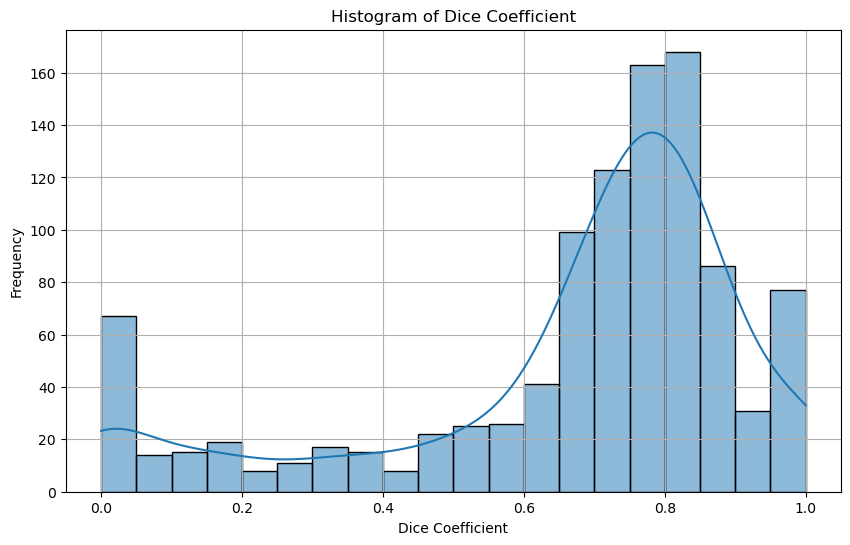

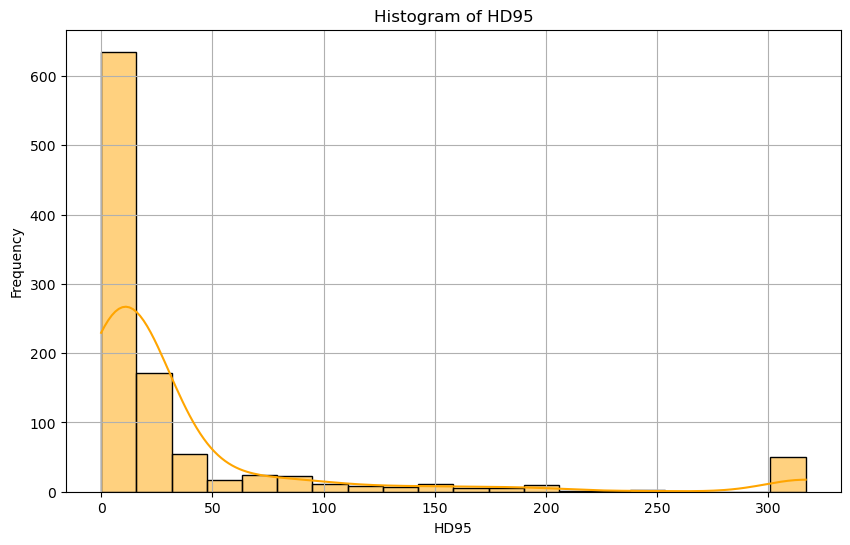

In [35]:
test_results

# Histagram of Dice Coefficient
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# Convert Test Results to Pandas DataFrame
test_results_df = pd.DataFrame([
    {
        'Filename': d['filename'],
        'Dice Coefficient': d['metrics'][0][0],
        'HD95': d['metrics'][0][1]
    }
    for d in test_results
])

test_results_df['City'] = test_results_df['Filename'].apply(lambda x: x.split('_')[0])
test_results_df['Image'] = test_results_df['Filename'].apply(lambda x: x.split('_')[1])


print("Median Scores:", test_results_df[['Dice Coefficient', 'HD95']].median())
print("Uper Quartile Scores:", test_results_df[['Dice Coefficient', 'HD95']].quantile(0.75))
print("Lower Quartile Scores:", test_results_df[['Dice Coefficient', 'HD95']].quantile(0.25))


# Plot histogram of Dice Coefficient
plt.figure(figsize=(10, 6))
sns.histplot(test_results_df['Dice Coefficient'], bins=20, kde=True)
plt.title('Histogram of Dice Coefficient')
plt.xlabel('Dice Coefficient')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Plot histogram of HD95
plt.figure(figsize=(10, 6))
sns.histplot(test_results_df['HD95'], bins=20, kde=True, color='orange')
median_hd95 = np.median(test_results_df['HD95'])
plt.title('Histogram of HD95')
plt.xlabel('HD95')
plt.ylabel('Frequency')
plt.grid()
plt.show()



### Scores By City

In [36]:
# See Cties
test_results_df['City'].unique()

array(['Chongqing', 'Guangzhou', 'Lanzhou', 'Ningbo', 'Shenzhen',
       'Tianjin'], dtype=object)

Scores by City:


City  Dice Coefficient Mean  Dice Coefficient Std  HD95 Mean  \
0  Chongqing               0.657283              0.266989  39.843414   
1  Guangzhou               0.620714              0.284802  50.287700   
2    Lanzhou               0.682296              0.305583  43.191138   
3     Ningbo               0.717564              0.175294  19.575686   
4   Shenzhen               0.656932              0.217065  25.789896   
5    Tianjin               0.675327              0.298883  51.402589   
6    Overall               0.667614              0.264924  38.981042   

    HD95 Std  
0  71.298229  
1  85.189902  
2  82.875128  
3  25.104941  
4  45.305851  
5  92.933056  
6  72.979437

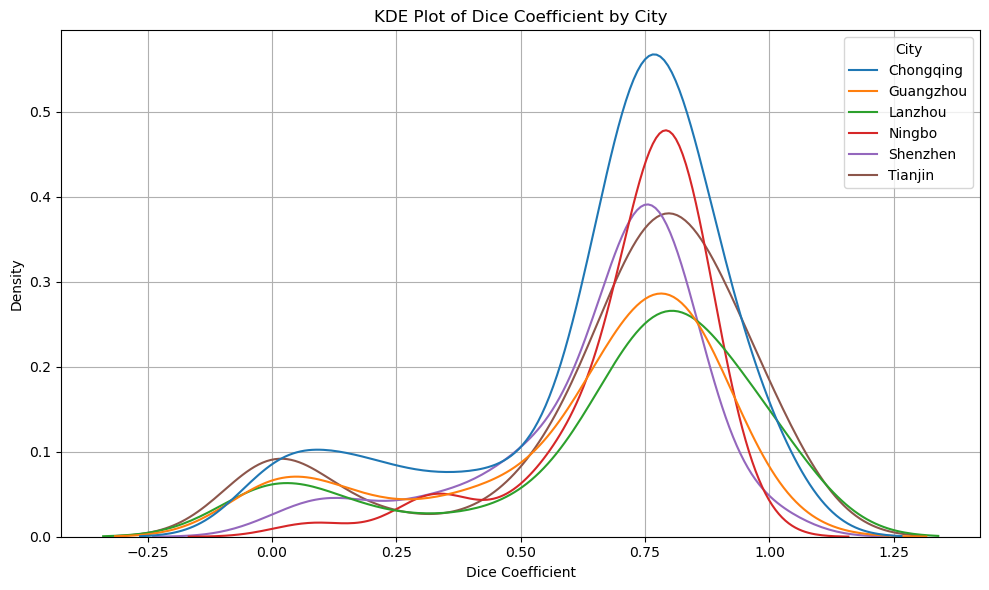

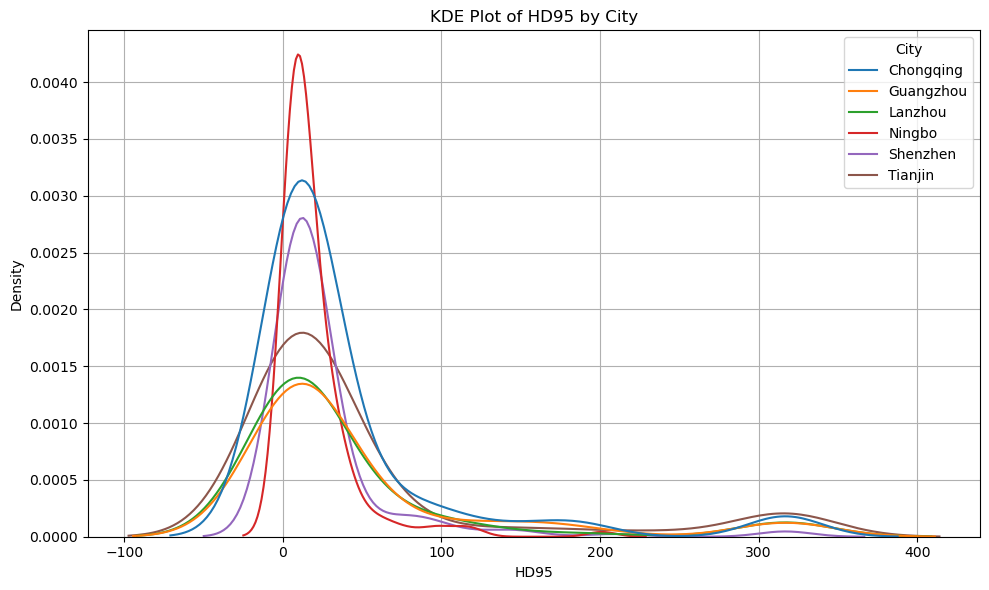

In [37]:
# Scores By City
by_city_result = test_results_df.groupby('City').agg({
    'Dice Coefficient': ['mean', 'std'],
    'HD95': ['mean', 'std']
}).reset_index()

# Rename columns for clarity
by_city_result.columns = ['City', 'Dice Coefficient Mean', 'Dice Coefficient Std', 'HD95 Mean', 'HD95 Std']

# Add Row for Overall
overall_row = pd.DataFrame({
    'City': ['Overall'],
    'Dice Coefficient Mean': [test_results_df['Dice Coefficient'].mean()],
    'Dice Coefficient Std': [test_results_df['Dice Coefficient'].std()],
    'HD95 Mean': [test_results_df['HD95'].mean()],
    'HD95 Std': [test_results_df['HD95'].std()],
})

by_city_result = pd.concat([by_city_result, overall_row], ignore_index=True)

# Display the results as a rendered table
print("Scores by City:")
display(by_city_result)

# Histogram of Dice Coefficient by City
plt.figure(figsize=(10, 6))
sns.kdeplot(data=test_results_df, x='Dice Coefficient', hue='City')
plt.title('KDE Plot of Dice Coefficient by City')
plt.xlabel('Dice Coefficient')
plt.ylabel('Density')
plt.grid()
plt.tight_layout()
plt.show()

# Histogram of HD95 by City
plt.figure(figsize=(10, 6))
sns.kdeplot(data=test_results_df, x='HD95', hue='City')
plt.title('KDE Plot of HD95 by City')
plt.xlabel('HD95')
plt.ylabel('Density')
plt.grid()
plt.tight_layout()
plt.show()



### First 5 and Last 5 Cases

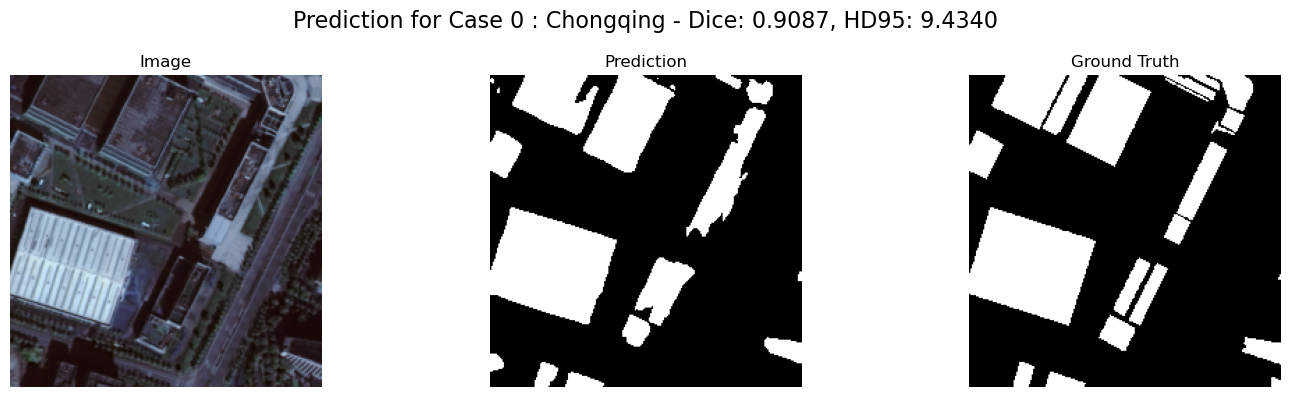

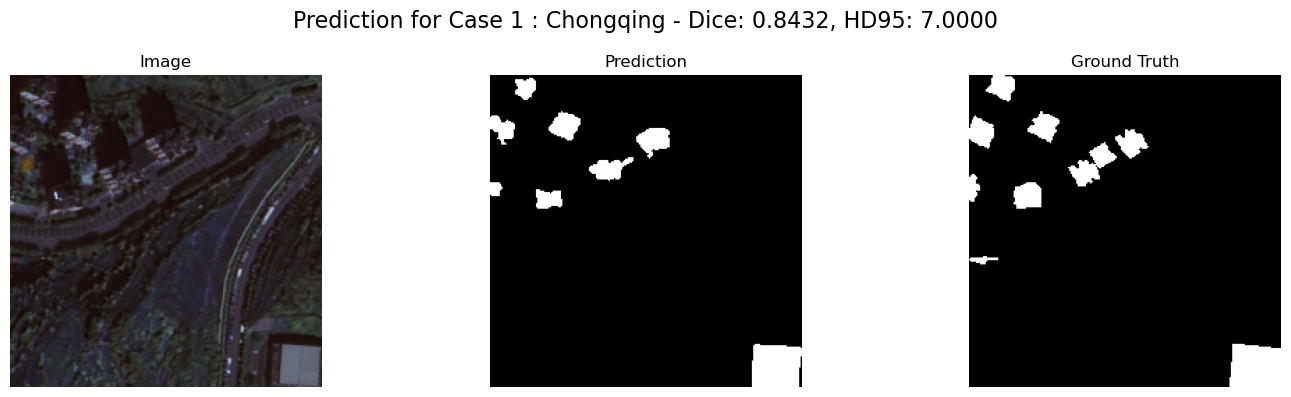

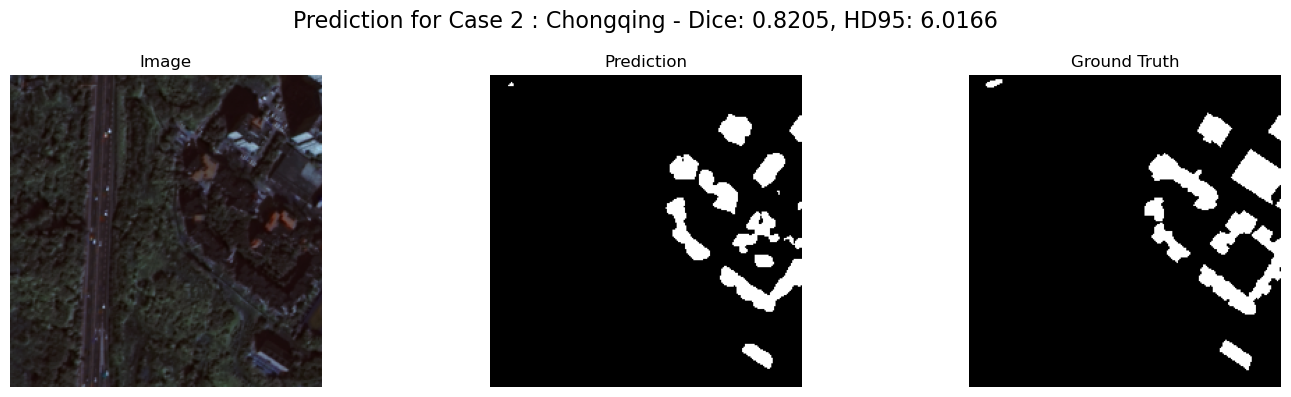

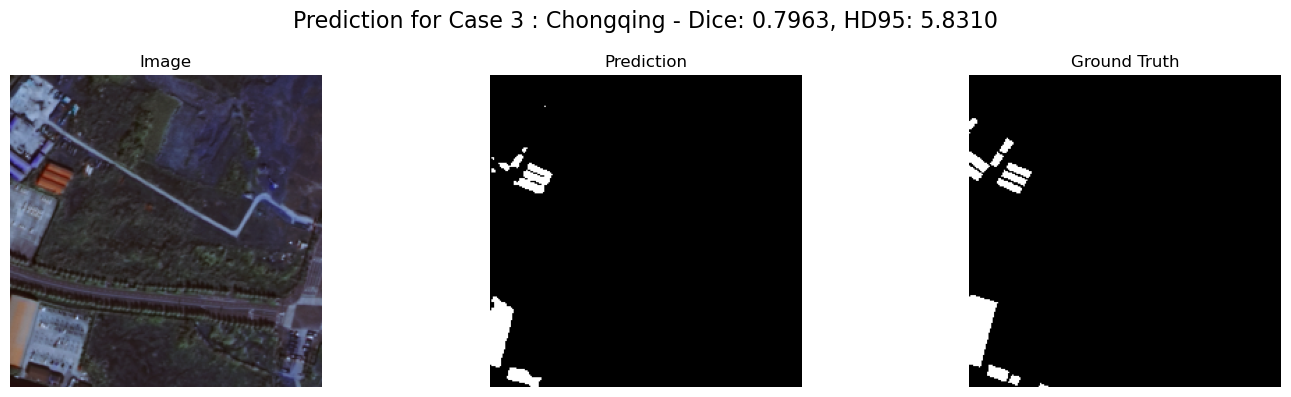

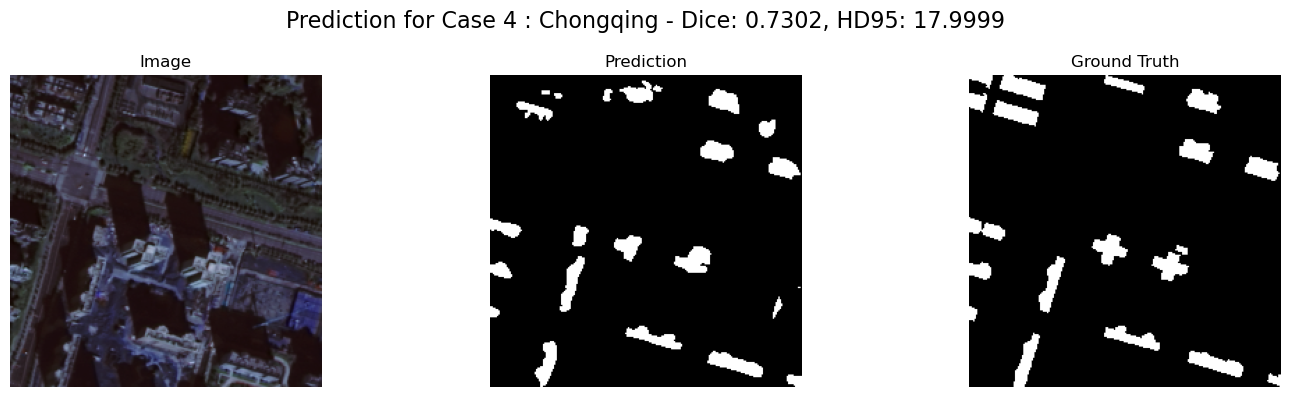

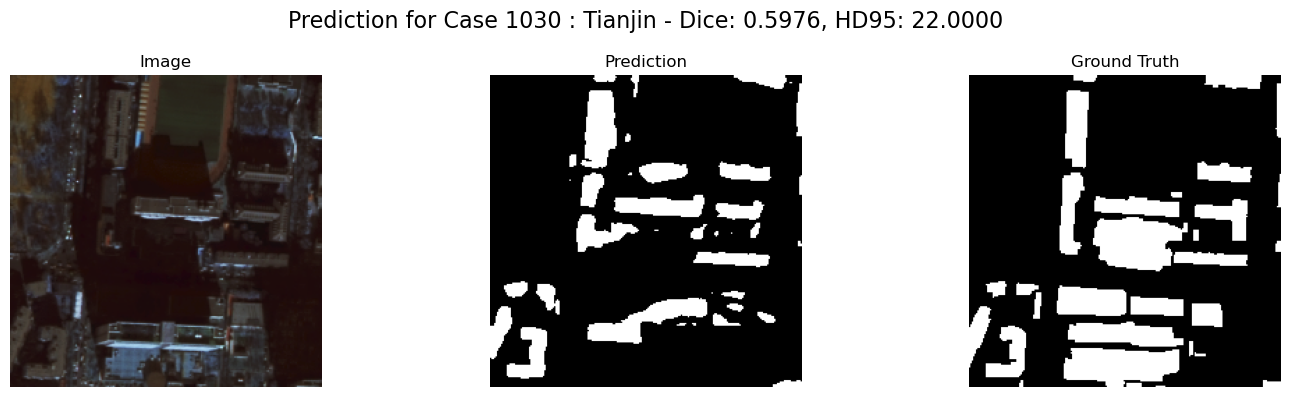

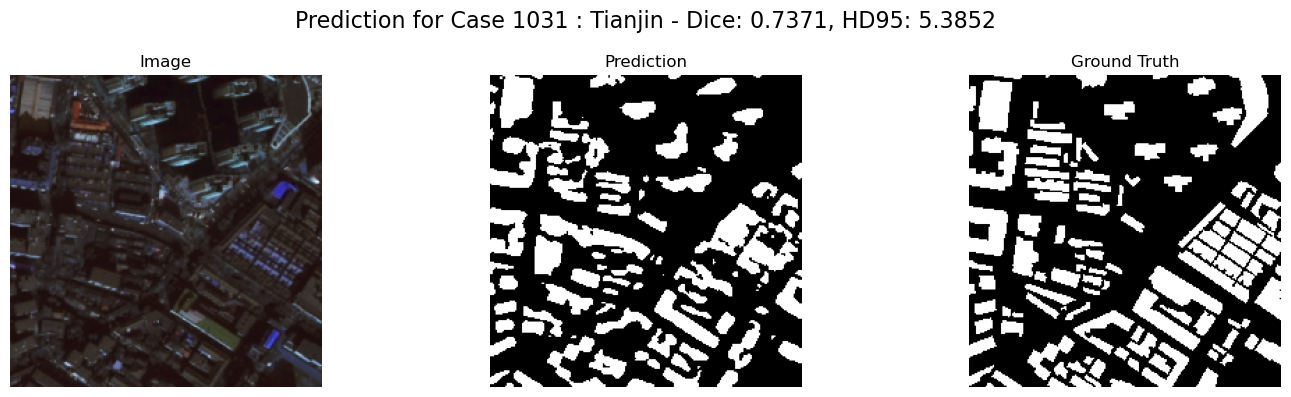

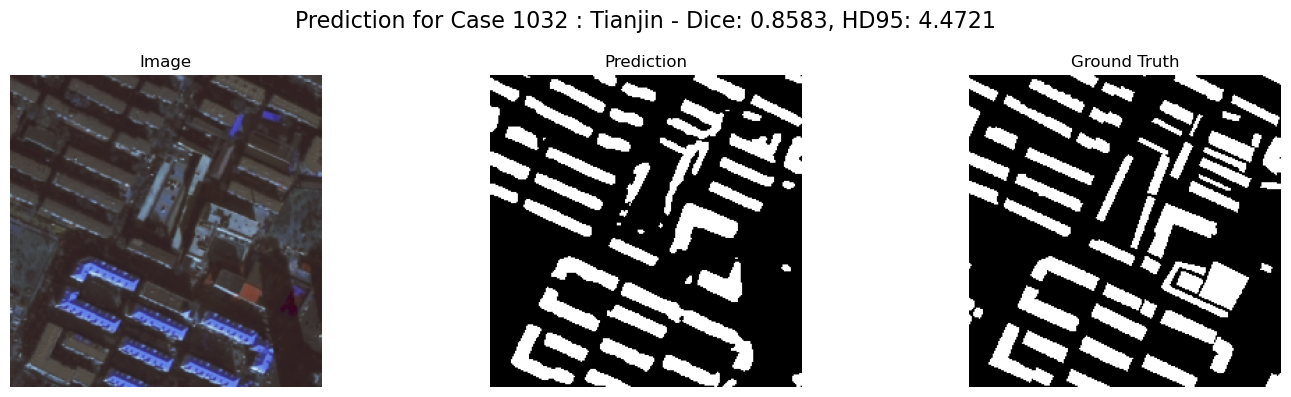

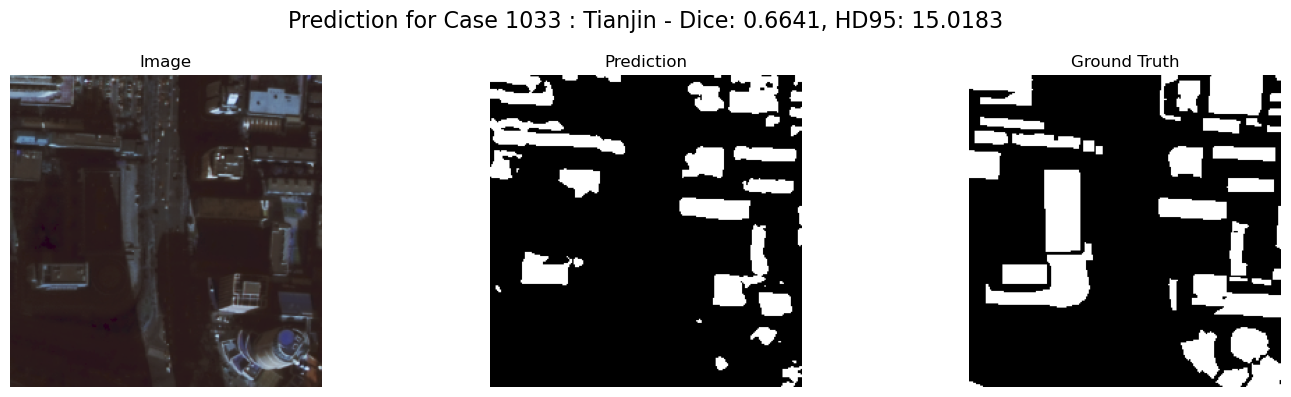

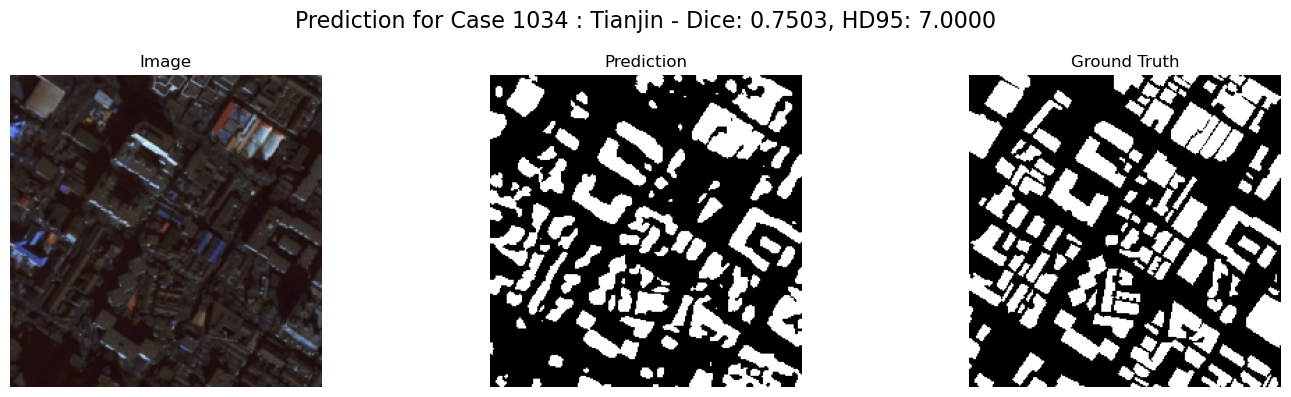

In [38]:
def plot_prediction(idx, title):
    # Load image, prediction, and ground truth from saved .nii.gz files
    img_path = os.path.join(test_save_path, f"{idx}_img.nii.gz")
    pred_path = os.path.join(test_save_path, f"{idx}_pred.nii.gz")
    gt_path = os.path.join(test_save_path, f"{idx}_gt.nii.gz")

    img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
    pred = sitk.GetArrayFromImage(sitk.ReadImage(pred_path))
    gt = sitk.GetArrayFromImage(sitk.ReadImage(gt_path))

    plt.figure(figsize=(15, 4))
    plt.suptitle(title, fontsize=16)
    plt.subplot(1, 3, 1)
    if img.shape[0] == 3:
        # Normalize to [0, 1] for RGB display
        img_disp = img.astype(np.float32)
        img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min() + 1e-8)
        plt.imshow(img_disp.transpose(1, 2, 0))
    else:
        plt.imshow(img[0], cmap='gray')
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(pred, cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(gt, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')
    
    # Add Dice Coefficient and HD95 to the title
    dice = test_results_df.iloc[idx]['Dice Coefficient']
    hd95 = test_results_df.iloc[idx]['HD95']
    City = test_results_df.iloc[idx]['City']
    
    plt.suptitle(f"{title} : {City} - Dice: {dice:.4f}, HD95: {hd95:.4f}", fontsize=16)
    # Increase padding between suptitle and subplots
    plt.subplots_adjust(top=0.85)
    plt.tight_layout()
    
    plt.show()
    
# Plot predictions for the first 5 cases
for i in range(5):
    plot_prediction(i, f"Prediction for Case {i}")
# Plot predictions for the last 5 cases
for i in range(len(test_results)-5, len(test_results)):
    plot_prediction(i, f"Prediction for Case {i}")

### Dice Score 1 vs 0

Best 5 Cases (Highest Dice Coefficient): [6, 18, 23, 53, 58]


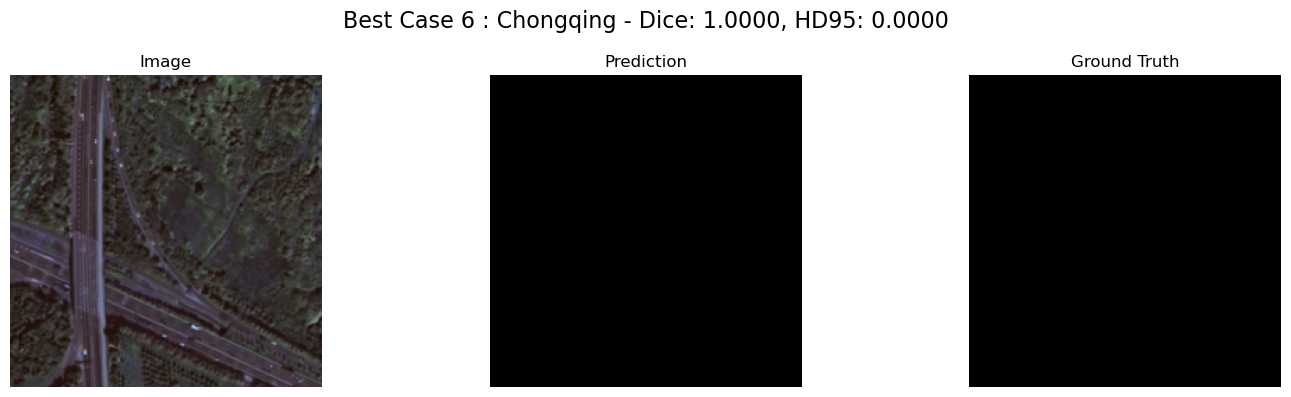

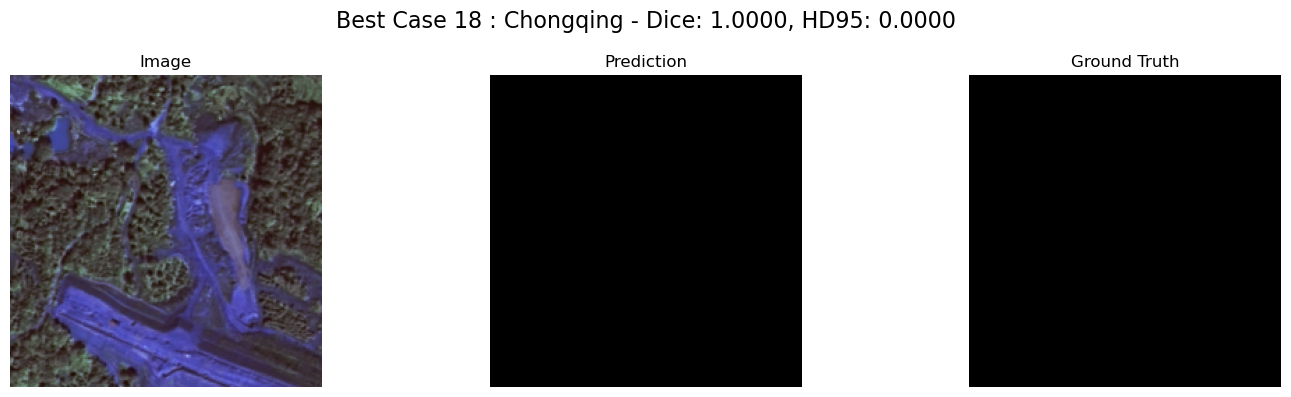

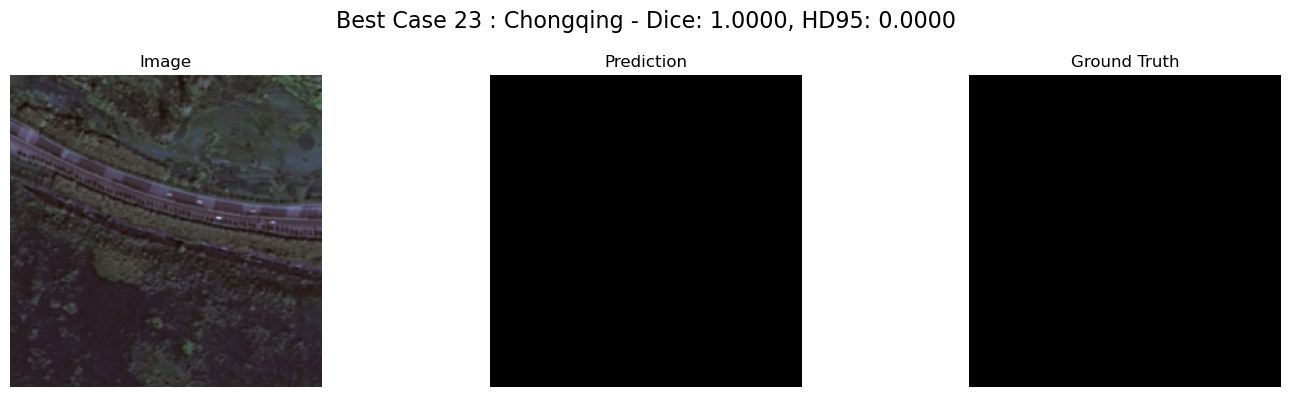

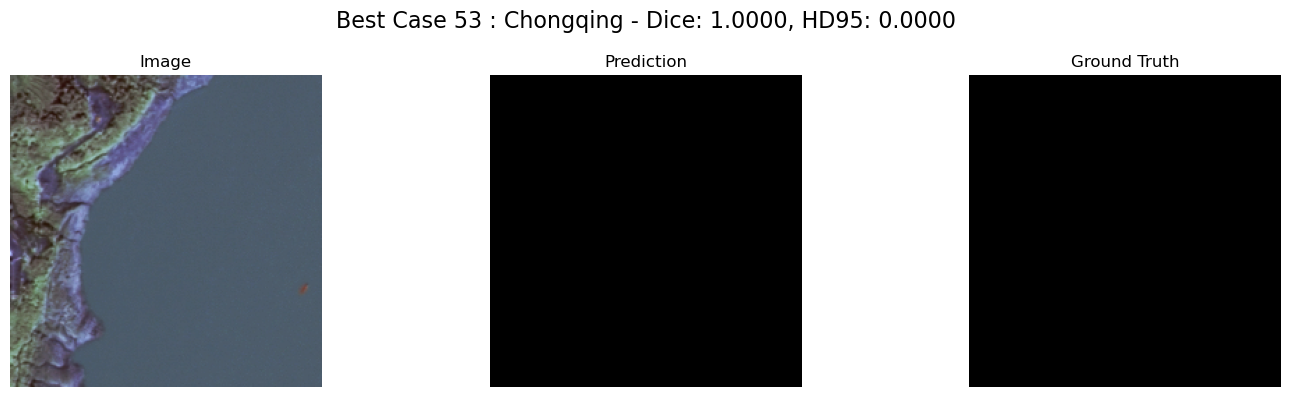

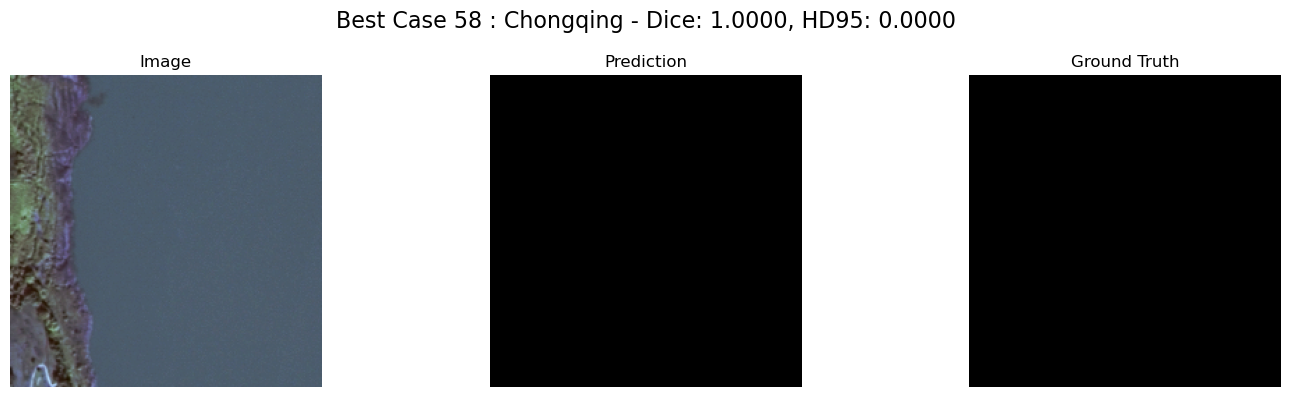

Worst 5 Cases (Lowest Dice Coefficient): [13, 49, 63, 66, 71]


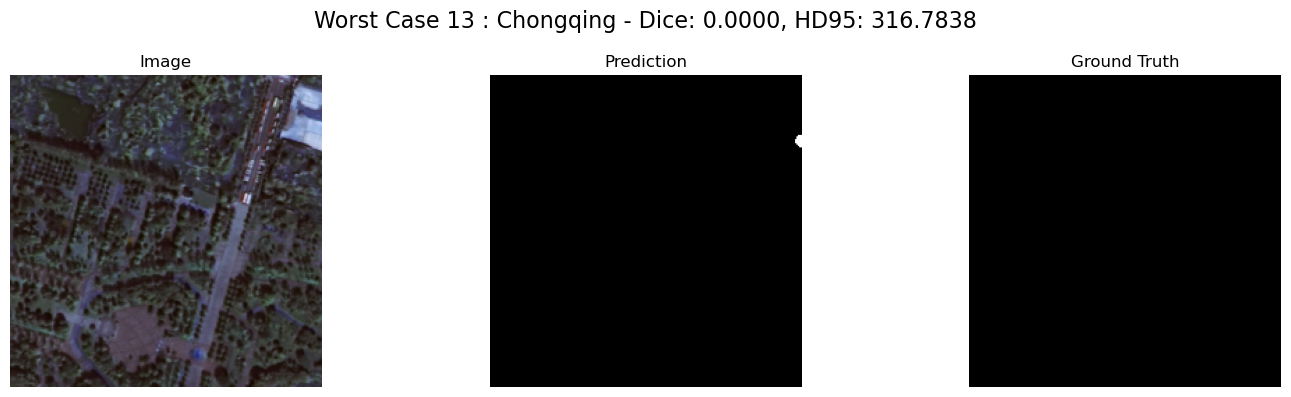

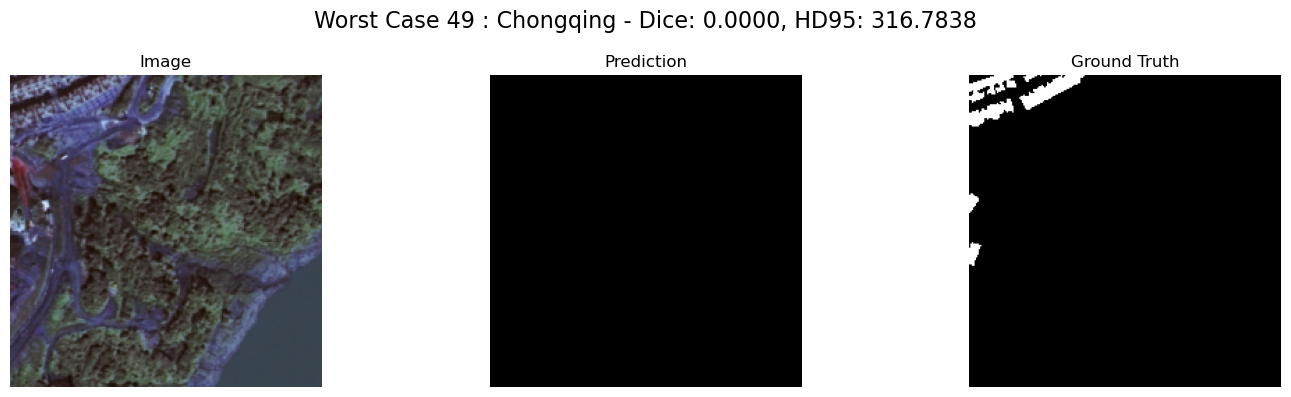

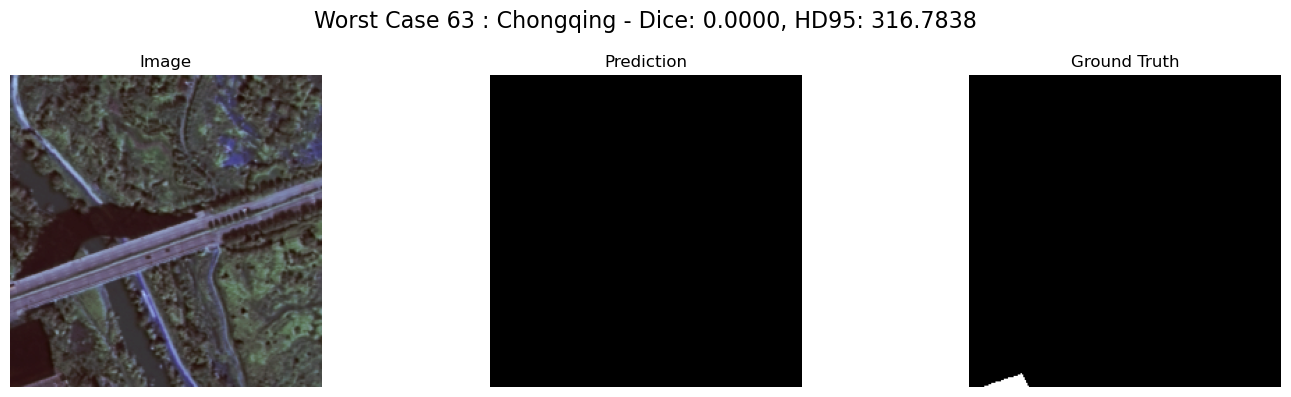

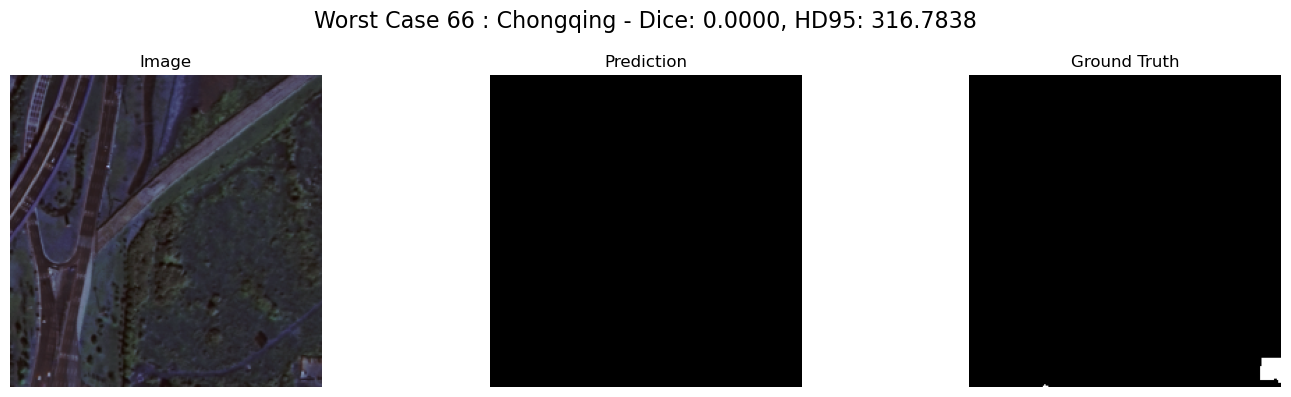

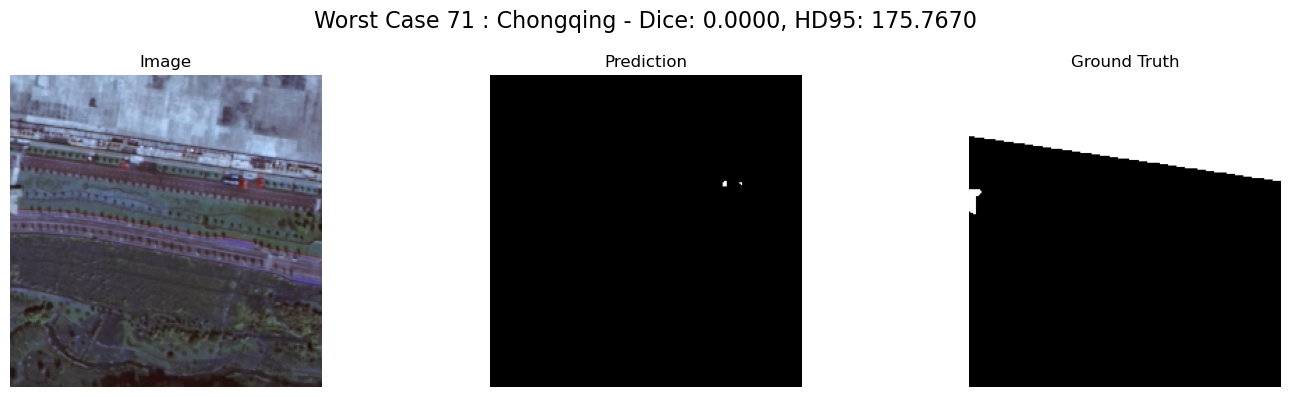

In [39]:
# Best 5 and Worst 5 Cases images

# Get the indices of the best and worst 5 cases based on Dice Coefficient
best_5_cases = test_results_df['Dice Coefficient'].nlargest(5).index
worst_5_cases = test_results_df['Dice Coefficient'].nsmallest(5).index

# Plot the best 5 cases
print("Best 5 Cases (Highest Dice Coefficient):", best_5_cases.tolist())
for i in best_5_cases:
    plot_prediction(i, f"Best Case {i}")

# Plot the worst 5 cases
print("Worst 5 Cases (Lowest Dice Coefficient):", worst_5_cases.tolist())
for i in worst_5_cases:
    plot_prediction(i, f"Worst Case {i}")

## Best and Worst Scores Ignoring 0 and 1 Scores

Best 5 Cases (Highest Dice Coefficient):


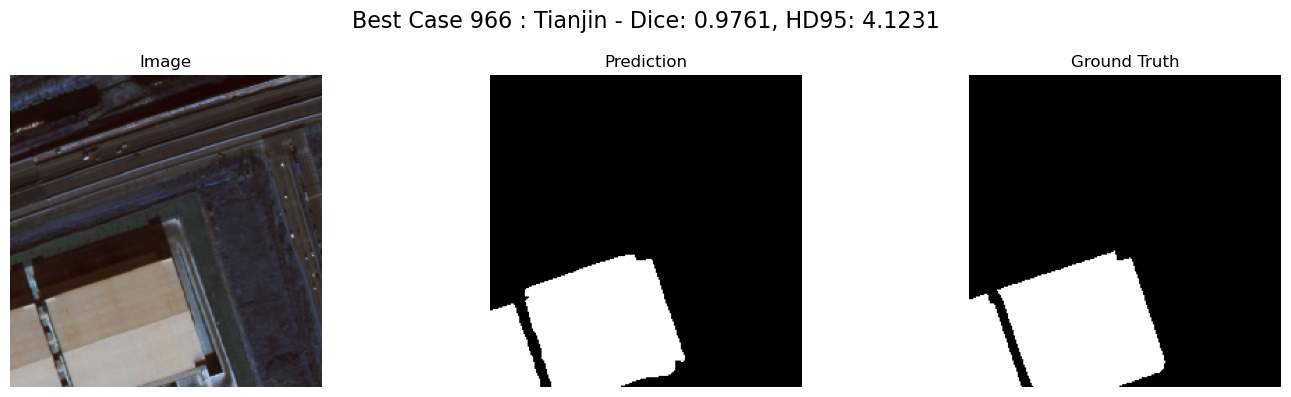

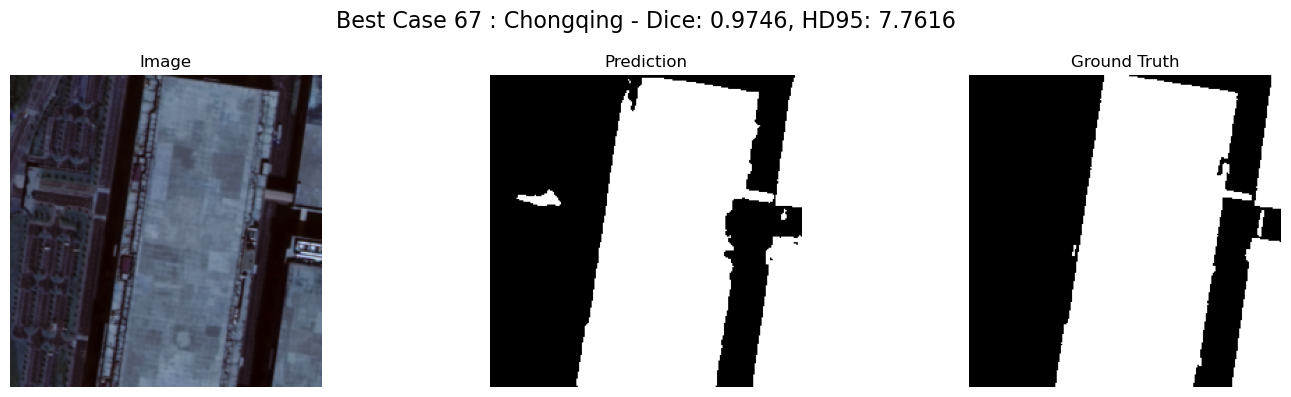

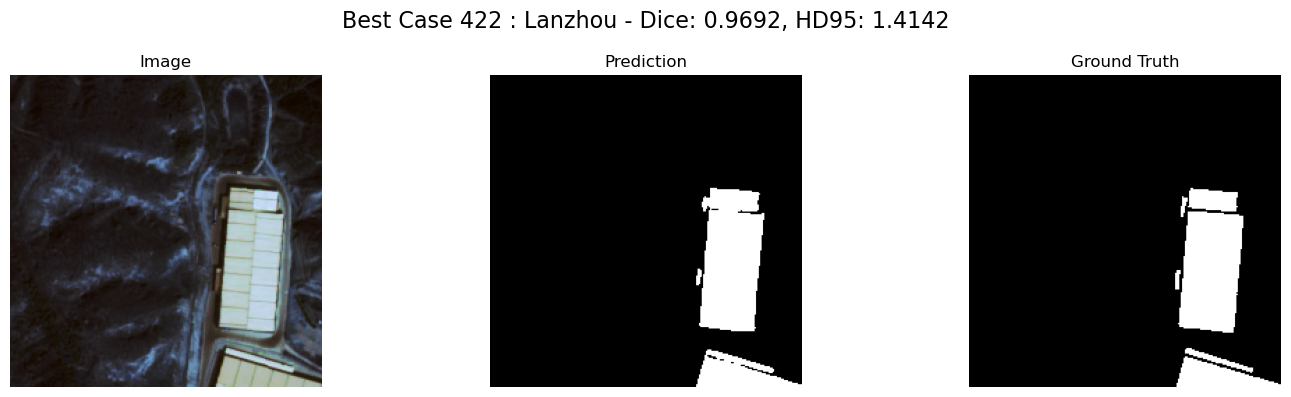

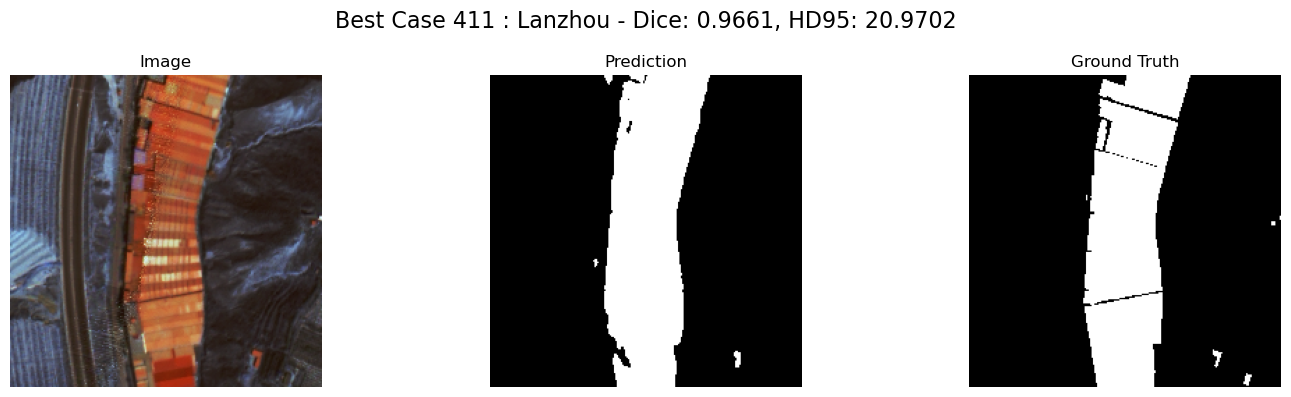

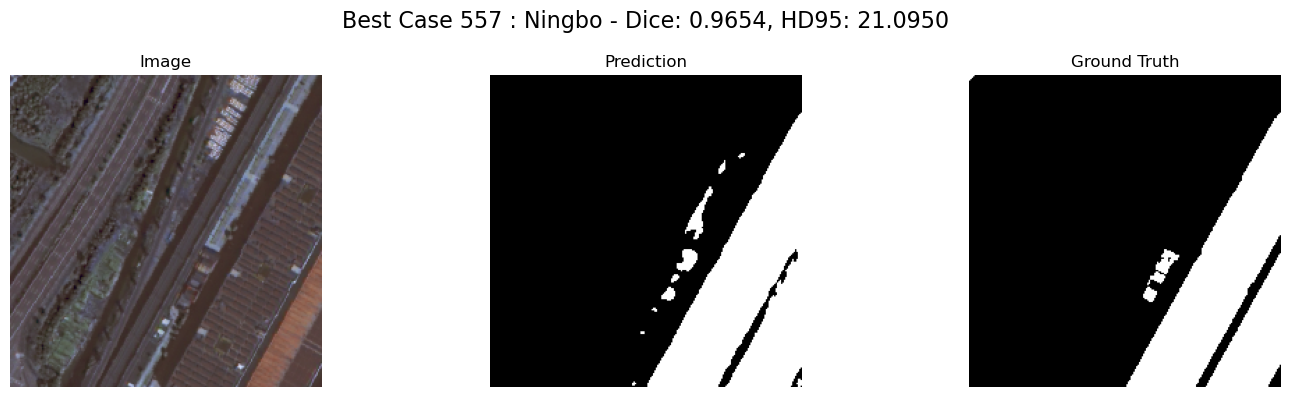

Worst 5 Cases (Lowest Dice Coefficient):


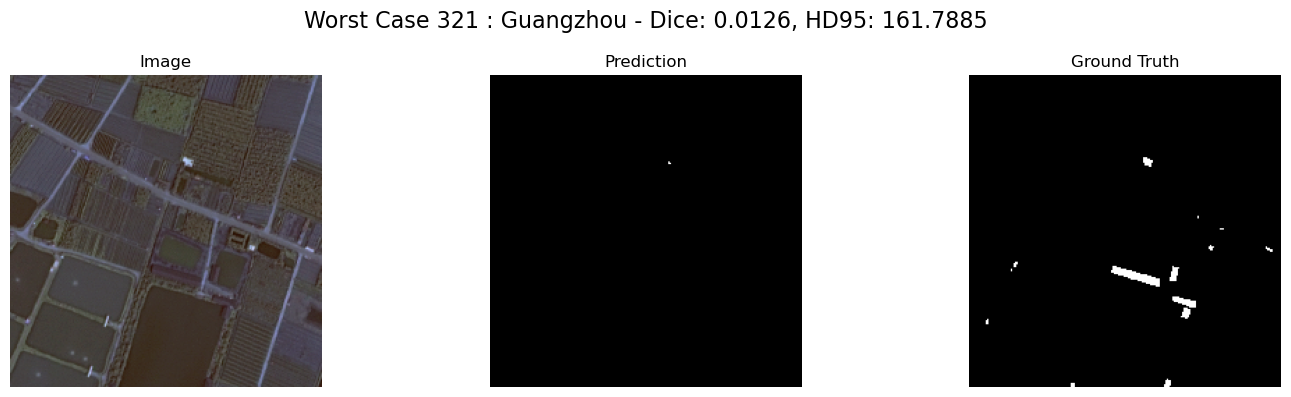

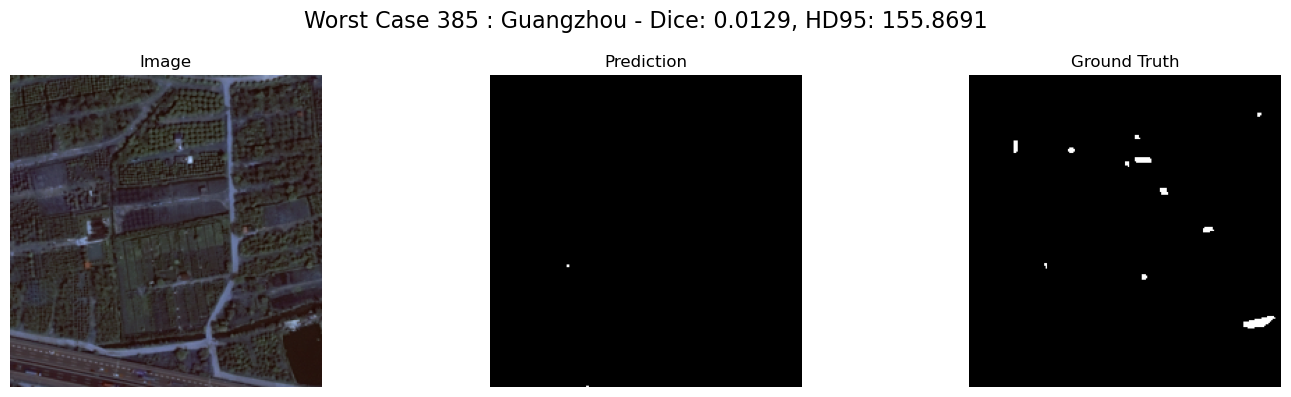

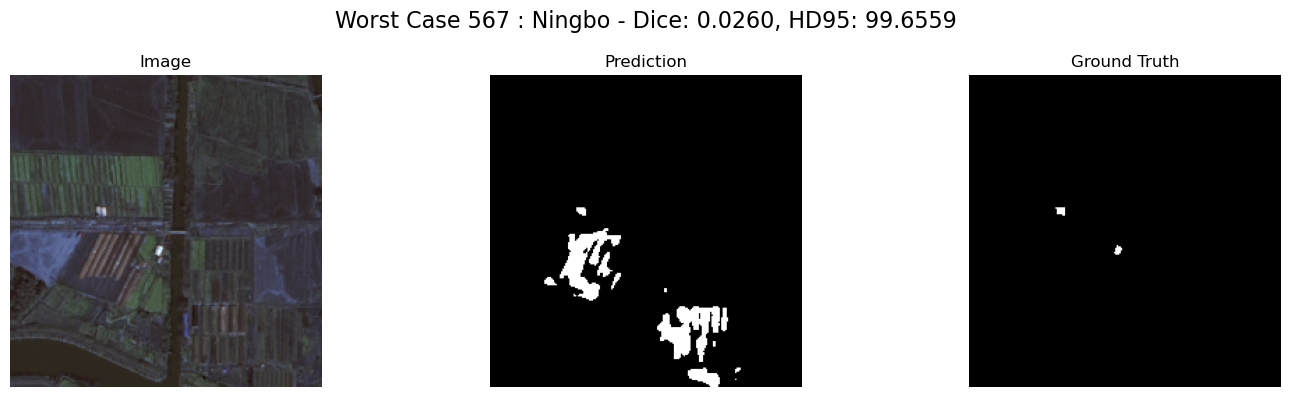

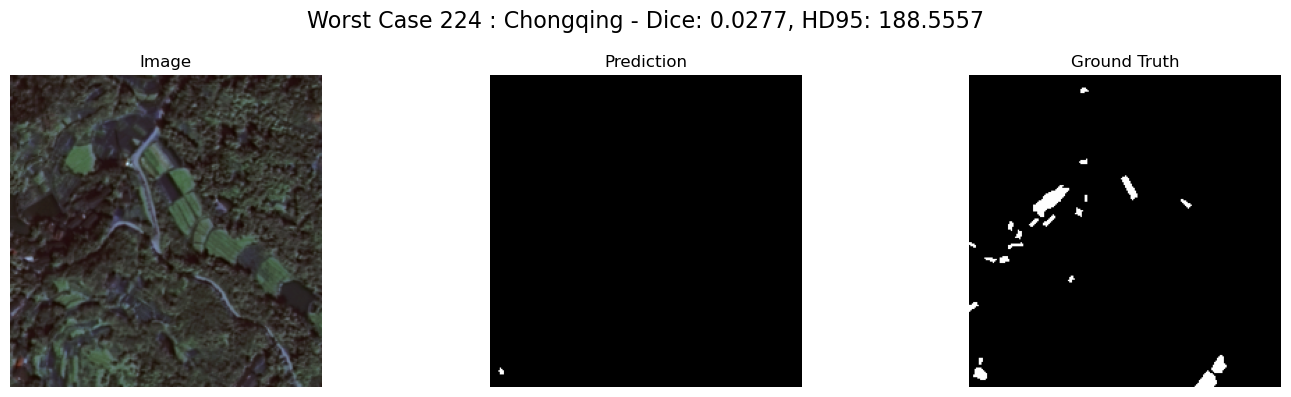

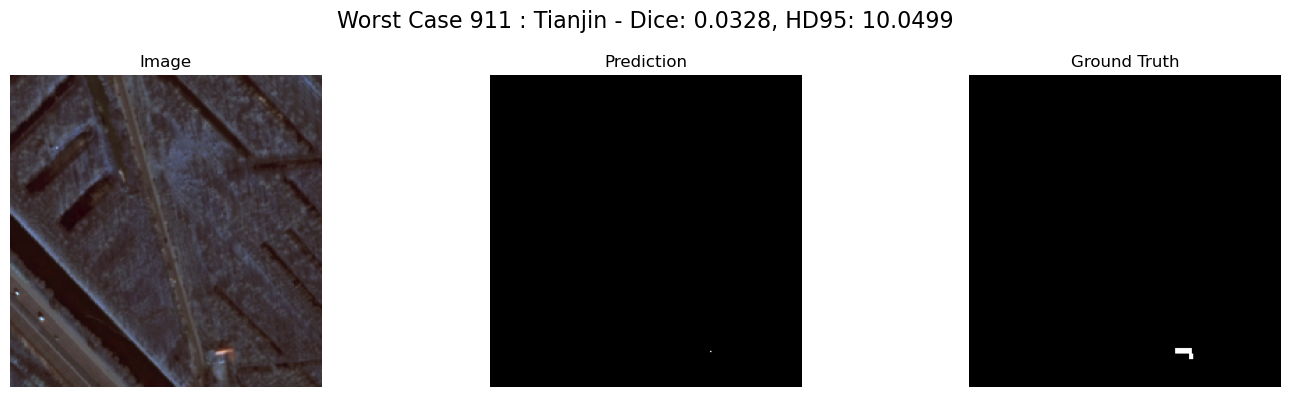

In [40]:
# Best 5 and Worst 5 Cases images

# Get the indices of the best and worst 5 cases based on Dice Coefficient, ignoring perfect (1.0) and zero (0.0) scores
filtered_df = test_results_df[(test_results_df['Dice Coefficient'] < 1.0) & (test_results_df['Dice Coefficient'] > 0.0)]
best_5_cases = filtered_df['Dice Coefficient'].nlargest(5).index
worst_5_cases = filtered_df['Dice Coefficient'].nsmallest(5).index

# Plot the best 5 cases
print("Best 5 Cases (Highest Dice Coefficient):")
for i in best_5_cases:
    plot_prediction(i, f"Best Case {i}")

# Plot the worst 5 cases
print("Worst 5 Cases (Lowest Dice Coefficient):")
for i in worst_5_cases:
    plot_prediction(i, f"Worst Case {i}")

## Model Structure

In [41]:
from torchsummary import summary

# Visualize the VisionTransformer model structure
# Use a sample input size matching your data (e.g., 3x224x224 for RGB images)
summary(net, input_size=(3, args.img_size, args.img_size), device=str(device))


# from torchviz import make_dot
# import graphviz

# # Create a dummy input matching model's input shape
# dummy_input = torch.randn(1, 3, args.img_size, args.img_size).to(device)

# # Forward pass to get the output
# output = net(dummy_input)

# Create the visualization
#dot = make_dot(output, params=dict(net.named_parameters()))
#dot.render("model_visualization", format="pdf")

Layer (type:depth-idx)                             Param #
├─Transformer: 1-1                                 --
|    └─Embeddings: 2-1                             --
|    |    └─ResNetV2: 3-1                          11,894,848
|    |    └─Conv2d: 3-2                            787,200
|    |    └─Dropout: 3-3                           --
|    └─Encoder: 2-2                                --
|    |    └─ModuleList: 3-4                        85,054,464
|    |    └─LayerNorm: 3-5                         1,536
├─DecoderCup: 1-2                                  --
|    └─Conv2dReLU: 2-3                             --
|    |    └─Conv2d: 3-6                            3,538,944
|    |    └─BatchNorm2d: 3-7                       1,024
|    |    └─ReLU: 3-8                              --
|    └─ModuleList: 2-4                             --
|    |    └─DecoderBlock: 3-9                      2,950,144
|    |    └─DecoderBlock: 3-10                     737,792
|    |    └─DecoderBlock: 3-11 

Layer (type:depth-idx)                             Param #
├─Transformer: 1-1                                 --
|    └─Embeddings: 2-1                             --
|    |    └─ResNetV2: 3-1                          11,894,848
|    |    └─Conv2d: 3-2                            787,200
|    |    └─Dropout: 3-3                           --
|    └─Encoder: 2-2                                --
|    |    └─ModuleList: 3-4                        85,054,464
|    |    └─LayerNorm: 3-5                         1,536
├─DecoderCup: 1-2                                  --
|    └─Conv2dReLU: 2-3                             --
|    |    └─Conv2d: 3-6                            3,538,944
|    |    └─BatchNorm2d: 3-7                       1,024
|    |    └─ReLU: 3-8                              --
|    └─ModuleList: 2-4                             --
|    |    └─DecoderBlock: 3-9                      2,950,144
|    |    └─DecoderBlock: 3-10                     737,792
|    |    └─DecoderBlock: 3-11 

### Detailed Breakdown

In [42]:
summary(net, input_size=(3, args.img_size, args.img_size), device=str(device), depth=6)

Layer (type:depth-idx)                                  Param #
├─Transformer: 1-1                                      --
|    └─Embeddings: 2-1                                  --
|    |    └─ResNetV2: 3-1                               --
|    |    |    └─Sequential: 4-1                        --
|    |    |    |    └─StdConv2d: 5-1                    9,408
|    |    |    |    └─GroupNorm: 5-2                    128
|    |    |    |    └─ReLU: 5-3                         --
|    |    |    └─Sequential: 4-2                        --
|    |    |    |    └─Sequential: 5-4                   --
|    |    |    |    |    └─PreActBottleneck: 6-1        75,008
|    |    |    |    |    └─PreActBottleneck: 6-2        70,400
|    |    |    |    |    └─PreActBottleneck: 6-3        70,400
|    |    |    |    └─Sequential: 5-5                   --
|    |    |    |    |    └─PreActBottleneck: 6-4        379,392
|    |    |    |    |    └─PreActBottleneck: 6-5        280,064
|    |    |    |    |    

Layer (type:depth-idx)                                  Param #
├─Transformer: 1-1                                      --
|    └─Embeddings: 2-1                                  --
|    |    └─ResNetV2: 3-1                               --
|    |    |    └─Sequential: 4-1                        --
|    |    |    |    └─StdConv2d: 5-1                    9,408
|    |    |    |    └─GroupNorm: 5-2                    128
|    |    |    |    └─ReLU: 5-3                         --
|    |    |    └─Sequential: 4-2                        --
|    |    |    |    └─Sequential: 5-4                   --
|    |    |    |    |    └─PreActBottleneck: 6-1        75,008
|    |    |    |    |    └─PreActBottleneck: 6-2        70,400
|    |    |    |    |    └─PreActBottleneck: 6-3        70,400
|    |    |    |    └─Sequential: 5-5                   --
|    |    |    |    |    └─PreActBottleneck: 6-4        379,392
|    |    |    |    |    └─PreActBottleneck: 6-5        280,064
|    |    |    |    |    

## Testing Multiple Models

Testing all models in directory...
Found 28 model files:
  - epoch_104_iter_13125.pth
  - epoch_109_iter_13750.pth
  - epoch_114_iter_14375.pth
  - epoch_119_iter_15000.pth
  - epoch_124_iter_15625.pth
  - epoch_129_iter_16250.pth
  - epoch_134_iter_16875.pth
  - epoch_139_iter_17500.pth
  - epoch_144_iter_18125.pth
  - epoch_149.pth
  - epoch_149_iter_18750.pth
  - epoch_154_iter_19375.pth
  - epoch_159_iter_20000.pth
  - epoch_164_iter_20625.pth
  - epoch_169_iter_21250.pth
  - epoch_174_iter_21875.pth
  - epoch_179_iter_22500.pth
  - epoch_184_iter_23125.pth
  - epoch_189_iter_23750.pth
  - epoch_194_iter_24375.pth
  - epoch_199.pth
  - epoch_199_iter_25000.pth
  - epoch_204.pth
  - epoch_204_iter_25625.pth
  - epoch_89_iter_11250.pth
  - epoch_94_iter_11875.pth
  - epoch_99_iter_12500.pth
  - LOW_CE_epoch_172_iter_21625_loss_0.0550.pth

Testing Model: epoch_104_iter_13125
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_104_iter_

Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_104_iter_13125
epoch_104_iter_13125: Mean Dice = 0.6599, Std = 0.2550
epoch_104_iter_13125: Median Dice = 0.7405, Std = 0.2550

--------------------------------------------------
epoch_104_iter_13125: Mean HD95 = 41.0623, Std = 73.8857
epoch_104_iter_13125: Median HD95 = 12.4416, Std = 73.8857

Testing Model: epoch_109_iter_13750
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_109_iter_13750.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_109_iter_13750
epoch_109_iter_13750: Mean Dice = 0.6405, Std = 0.2715
epoch_109_iter_13750: Median Dice = 0.7192, Std = 0.2715

--------------------------------------------------
epoch_109_iter_13750: Mean HD95 = 41.0383, Std = 75.7315
epoch_109_iter_13750: Median HD95 = 13.0384, Std = 75.7315

Testing Model: epoch_114_iter_14375
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_114_iter_14375.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_114_iter_14375
epoch_114_iter_14375: Mean Dice = 0.6429, Std = 0.2764
epoch_114_iter_14375: Median Dice = 0.7307, Std = 0.2764

--------------------------------------------------
epoch_114_iter_14375: Mean HD95 = 42.8830, Std = 77.6811
epoch_114_iter_14375: Median HD95 = 12.9709, Std = 77.6811

Testing Model: epoch_119_iter_15000
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_119_iter_15000.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_119_iter_15000
epoch_119_iter_15000: Mean Dice = 0.6600, Std = 0.2609
epoch_119_iter_15000: Median Dice = 0.7434, Std = 0.2609

--------------------------------------------------
epoch_119_iter_15000: Mean HD95 = 37.5714, Std = 71.7618
epoch_119_iter_15000: Median HD95 = 12.0000, Std = 71.7618

Testing Model: epoch_124_iter_15625
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_124_iter_15625.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_124_iter_15625
epoch_124_iter_15625: Mean Dice = 0.6405, Std = 0.2722
epoch_124_iter_15625: Median Dice = 0.7323, Std = 0.2722

--------------------------------------------------
epoch_124_iter_15625: Mean HD95 = 41.6769, Std = 75.7798
epoch_124_iter_15625: Median HD95 = 12.6784, Std = 75.7798

Testing Model: epoch_129_iter_16250
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_129_iter_16250.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_129_iter_16250
epoch_129_iter_16250: Mean Dice = 0.6660, Std = 0.2549
epoch_129_iter_16250: Median Dice = 0.7454, Std = 0.2549

--------------------------------------------------
epoch_129_iter_16250: Mean HD95 = 38.5839, Std = 72.6640
epoch_129_iter_16250: Median HD95 = 11.7047, Std = 72.6640

Testing Model: epoch_134_iter_16875
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_134_iter_16875.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_134_iter_16875
epoch_134_iter_16875: Mean Dice = 0.6682, Std = 0.2533
epoch_134_iter_16875: Median Dice = 0.7451, Std = 0.2533

--------------------------------------------------
epoch_134_iter_16875: Mean HD95 = 37.8314, Std = 71.9466
epoch_134_iter_16875: Median HD95 = 11.1803, Std = 71.9466

Testing Model: epoch_139_iter_17500
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_139_iter_17500.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_139_iter_17500
epoch_139_iter_17500: Mean Dice = 0.6496, Std = 0.2602
epoch_139_iter_17500: Median Dice = 0.7329, Std = 0.2602

--------------------------------------------------
epoch_139_iter_17500: Mean HD95 = 41.8484, Std = 76.9658
epoch_139_iter_17500: Median HD95 = 12.0416, Std = 76.9658

Testing Model: epoch_144_iter_18125
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_144_iter_18125.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_144_iter_18125
epoch_144_iter_18125: Mean Dice = 0.6583, Std = 0.2573
epoch_144_iter_18125: Median Dice = 0.7392, Std = 0.2573

--------------------------------------------------
epoch_144_iter_18125: Mean HD95 = 40.6024, Std = 75.1708
epoch_144_iter_18125: Median HD95 = 12.0416, Std = 75.1708

Testing Model: epoch_149
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_149.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_149
epoch_149: Mean Dice = 0.6624, Std = 0.2550
epoch_149: Median Dice = 0.7450, Std = 0.2550

--------------------------------------------------
epoch_149: Mean HD95 = 40.4459, Std = 75.1180
epoch_149: Median HD95 = 11.7047, Std = 75.1180

Testing Model: epoch_149_iter_18750
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_149_iter_18750.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_149_iter_18750
epoch_149_iter_18750: Mean Dice = 0.6624, Std = 0.2550
epoch_149_iter_18750: Median Dice = 0.7450, Std = 0.2550

--------------------------------------------------
epoch_149_iter_18750: Mean HD95 = 40.4459, Std = 75.1180
epoch_149_iter_18750: Median HD95 = 11.7047, Std = 75.1180

Testing Model: epoch_154_iter_19375
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_154_iter_19375.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_154_iter_19375
epoch_154_iter_19375: Mean Dice = 0.6744, Std = 0.2461
epoch_154_iter_19375: Median Dice = 0.7464, Std = 0.2461

--------------------------------------------------
epoch_154_iter_19375: Mean HD95 = 36.9096, Std = 70.4186
epoch_154_iter_19375: Median HD95 = 11.4018, Std = 70.4186

Testing Model: epoch_159_iter_20000
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_159_iter_20000.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_159_iter_20000
epoch_159_iter_20000: Mean Dice = 0.6755, Std = 0.2470
epoch_159_iter_20000: Median Dice = 0.7503, Std = 0.2470

--------------------------------------------------
epoch_159_iter_20000: Mean HD95 = 36.6984, Std = 69.6014
epoch_159_iter_20000: Median HD95 = 11.3137, Std = 69.6014

Testing Model: epoch_164_iter_20625
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_164_iter_20625.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_164_iter_20625
epoch_164_iter_20625: Mean Dice = 0.6383, Std = 0.2679
epoch_164_iter_20625: Median Dice = 0.7339, Std = 0.2679

--------------------------------------------------
epoch_164_iter_20625: Mean HD95 = 50.7951, Std = 84.2740
epoch_164_iter_20625: Median HD95 = 13.6015, Std = 84.2740

Testing Model: epoch_169_iter_21250
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_169_iter_21250.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_169_iter_21250
epoch_169_iter_21250: Mean Dice = 0.6663, Std = 0.2543
epoch_169_iter_21250: Median Dice = 0.7457, Std = 0.2543

--------------------------------------------------
epoch_169_iter_21250: Mean HD95 = 38.2198, Std = 71.8587
epoch_169_iter_21250: Median HD95 = 11.7889, Std = 71.8587

Testing Model: epoch_174_iter_21875
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_174_iter_21875.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_174_iter_21875
epoch_174_iter_21875: Mean Dice = 0.6743, Std = 0.2486
epoch_174_iter_21875: Median Dice = 0.7519, Std = 0.2486

--------------------------------------------------
epoch_174_iter_21875: Mean HD95 = 36.5593, Std = 69.3240
epoch_174_iter_21875: Median HD95 = 11.1914, Std = 69.3240

Testing Model: epoch_179_iter_22500
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_179_iter_22500.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_179_iter_22500
epoch_179_iter_22500: Mean Dice = 0.6650, Std = 0.2506
epoch_179_iter_22500: Median Dice = 0.7443, Std = 0.2506

--------------------------------------------------
epoch_179_iter_22500: Mean HD95 = 37.2898, Std = 70.6509
epoch_179_iter_22500: Median HD95 = 11.7047, Std = 70.6509

Testing Model: epoch_184_iter_23125
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_184_iter_23125.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_184_iter_23125
epoch_184_iter_23125: Mean Dice = 0.6675, Std = 0.2548
epoch_184_iter_23125: Median Dice = 0.7491, Std = 0.2548

--------------------------------------------------
epoch_184_iter_23125: Mean HD95 = 38.7836, Std = 73.9823
epoch_184_iter_23125: Median HD95 = 11.7047, Std = 73.9823

Testing Model: epoch_189_iter_23750
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_189_iter_23750.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_189_iter_23750
epoch_189_iter_23750: Mean Dice = 0.6777, Std = 0.2440
epoch_189_iter_23750: Median Dice = 0.7509, Std = 0.2440

--------------------------------------------------
epoch_189_iter_23750: Mean HD95 = 36.8867, Std = 70.1875
epoch_189_iter_23750: Median HD95 = 11.2246, Std = 70.1875

Testing Model: epoch_194_iter_24375
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_194_iter_24375.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_194_iter_24375
epoch_194_iter_24375: Mean Dice = 0.6593, Std = 0.2551
epoch_194_iter_24375: Median Dice = 0.7423, Std = 0.2551

--------------------------------------------------
epoch_194_iter_24375: Mean HD95 = 39.3182, Std = 73.0977
epoch_194_iter_24375: Median HD95 = 12.3529, Std = 73.0977

Testing Model: epoch_199
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_199.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_199
epoch_199: Mean Dice = 0.6643, Std = 0.2593
epoch_199: Median Dice = 0.7446, Std = 0.2593

--------------------------------------------------
epoch_199: Mean HD95 = 38.5217, Std = 71.4224
epoch_199: Median HD95 = 12.3693, Std = 71.4224

Testing Model: epoch_199_iter_25000
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_199_iter_25000.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_199_iter_25000
epoch_199_iter_25000: Mean Dice = 0.6643, Std = 0.2593
epoch_199_iter_25000: Median Dice = 0.7446, Std = 0.2593

--------------------------------------------------
epoch_199_iter_25000: Mean HD95 = 38.5217, Std = 71.4224
epoch_199_iter_25000: Median HD95 = 12.3693, Std = 71.4224

Testing Model: epoch_204
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_204.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_204
epoch_204: Mean Dice = 0.6676, Std = 0.2648
epoch_204: Median Dice = 0.7521, Std = 0.2648

--------------------------------------------------
epoch_204: Mean HD95 = 38.9810, Std = 72.9442
epoch_204: Median HD95 = 11.9114, Std = 72.9442

Testing Model: epoch_204_iter_25625
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_204_iter_25625.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_204_iter_25625
epoch_204_iter_25625: Mean Dice = 0.6676, Std = 0.2648
epoch_204_iter_25625: Median Dice = 0.7521, Std = 0.2648

--------------------------------------------------
epoch_204_iter_25625: Mean HD95 = 38.9810, Std = 72.9442
epoch_204_iter_25625: Median HD95 = 11.9114, Std = 72.9442

Testing Model: epoch_89_iter_11250
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_89_iter_11250.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_89_iter_11250
epoch_89_iter_11250: Mean Dice = 0.6493, Std = 0.2677
epoch_89_iter_11250: Median Dice = 0.7346, Std = 0.2677

--------------------------------------------------
epoch_89_iter_11250: Mean HD95 = 39.2757, Std = 74.0946
epoch_89_iter_11250: Median HD95 = 12.0416, Std = 74.0946

Testing Model: epoch_94_iter_11875
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_94_iter_11875.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_94_iter_11875
epoch_94_iter_11875: Mean Dice = 0.6469, Std = 0.2592
epoch_94_iter_11875: Median Dice = 0.7293, Std = 0.2592

--------------------------------------------------
epoch_94_iter_11875: Mean HD95 = 42.2143, Std = 76.8650
epoch_94_iter_11875: Median HD95 = 12.3693, Std = 76.8650

Testing Model: epoch_99_iter_12500
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\epoch_99_iter_12500.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: epoch_99_iter_12500
epoch_99_iter_12500: Mean Dice = 0.6303, Std = 0.2740
epoch_99_iter_12500: Median Dice = 0.7124, Std = 0.2740

--------------------------------------------------
epoch_99_iter_12500: Mean HD95 = 41.0827, Std = 74.7949
epoch_99_iter_12500: Median HD95 = 13.8924, Std = 74.7949

Testing Model: LOW_CE_epoch_172_iter_21625_loss_0.0550
Loading model from: model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42\LOW_CE_epoch_172_iter_21625_loss_0.0550.pth
Starting inference...
Testing on 1035 samples


Testing:   0%|          | 0/1035 [00:00<?, ?it/s]


Results For Model: LOW_CE_epoch_172_iter_21625_loss_0.0550
LOW_CE_epoch_172_iter_21625_loss_0.0550: Mean Dice = 0.6576, Std = 0.2608
LOW_CE_epoch_172_iter_21625_loss_0.0550: Median Dice = 0.7443, Std = 0.2608

--------------------------------------------------
LOW_CE_epoch_172_iter_21625_loss_0.0550: Mean HD95 = 40.5313, Std = 75.7627
LOW_CE_epoch_172_iter_21625_loss_0.0550: Median HD95 = 12.0000, Std = 75.7627

Model Comparison Results (Sorted by Mean Dice):


Model  Mean Dice  Std Dice  Mean HD95  \
18                     epoch_189_iter_23750   0.677743  0.243963  36.886725   
12                     epoch_159_iter_20000   0.675461  0.247043  36.698385   
11                     epoch_154_iter_19375   0.674354  0.246093  36.909639   
15                     epoch_174_iter_21875   0.674261  0.248616  36.559324   
6                      epoch_134_iter_16875   0.668217  0.253329  37.831377   
23                     epoch_204_iter_25625   0.667614  0.264796  38.981042   
22                                epoch_204   0.667614  0.264796  38.981042   
17                     epoch_184_iter_23125   0.667531  0.254807  38.783576   
14                     epoch_169_iter_21250   0.666271  0.254310  38.219818   
5                      epoch_129_iter_16250   0.665994  0.254919  38.583935   
16                     epoch_179_iter_22500   0.664961  0.250602  37.289788   
21                     epoch_199_iter_25000   0.664319  0.259328  38.521667   
20                                epoch_199   0.664319  0.259328  38.521667   
9                                 epoch_149   0.662411  0.254963  40.445895   
10                     epoch_149_iter_18750   0.662411  0.254963  40.445895   
3                      epoch_119_iter_15000   0.659964  0.260868  37.571387   
0                      epoch_104_iter_13125   0.659894  0.254978  41.062256   
19                     epoch_194_iter_24375   0.659335  0.255136  39.318228   
8                      epoch_144_iter_18125   0.658259  0.257282  40.602422   
27  LOW_CE_epoch_172_iter_21625_loss_0.0550   0.657580  0.260766  40.531267   
7                      epoch_139_iter_17500   0.649551  0.260241  41.848374   
24                      epoch_89_iter_11250   0.649295  0.267671  39.275711   
25                      epoch_94_iter_11875   0.646858  0.259209  42.214269   
2                      epoch_114_iter_14375   0.642919  0.276380  42.882991   
1                      epoch_109_iter_13750   0.640508  0.271460  41.038300   
4                      epoch_124_iter_15625   0.640457  0.272158  41.676942   
13                     epoch_164_iter_20625   0.638329  0.267910  50.795092   
26                      epoch_99_iter_12500   0.630334  0.274028  41.082651   

     Std HD95  Median Dice  Median HD95  Max Dice  Min Dice  
18  70.187516     0.750884    11.224623       1.0       0.0  
12  69.601449     0.750334    11.313708       1.0       0.0  
11  70.418578     0.746429    11.401754       1.0       0.0  
15  69.323958     0.751862    11.191411       1.0       0.0  
6   71.946602     0.745092    11.180340       1.0       0.0  
23  72.944172     0.752053    11.911410       1.0       0.0  
22  72.944172     0.752053    11.911410       1.0       0.0  
17  73.982343     0.749061    11.704700       1.0       0.0  
14  71.858740     0.745680    11.788924       1.0       0.0  
5   72.664031     0.745357    11.704700       1.0       0.0  
16  70.650880     0.744273    11.704700       1.0       0.0  
21  71.422429     0.744577    12.369317       1.0       0.0  
20  71.422429     0.744577    12.369317       1.0       0.0  
9   75.118000     0.745035    11.704700       1.0       0.0  
10  75.118000     0.745035    11.704700       1.0       0.0  
3   71.761825     0.743352    12.000000       1.0       0.0  
0   73.885697     0.740500    12.441608       1.0       0.0  
19  73.097673     0.742275    12.352931       1.0       0.0  
8   75.170757     0.739152    12.041595       1.0       0.0  
27  75.762732     0.744325    12.000000       1.0       0.0  
7   76.965766     0.732916    12.041595       1.0       0.0  
24  74.094584     0.734590    12.041595       1.0       0.0  
25  76.864979     0.729314    12.369317       1.0       0.0  
2   77.681118     0.730678    12.970937       1.0       0.0  
1   75.731528     0.719163    13.038405       1.0       0.0  
4   75.779837     0.732255    12.678433       1.0       0.0  
13  84.274011     0.733916    13.601471       1.0       0.0  
26  74.794

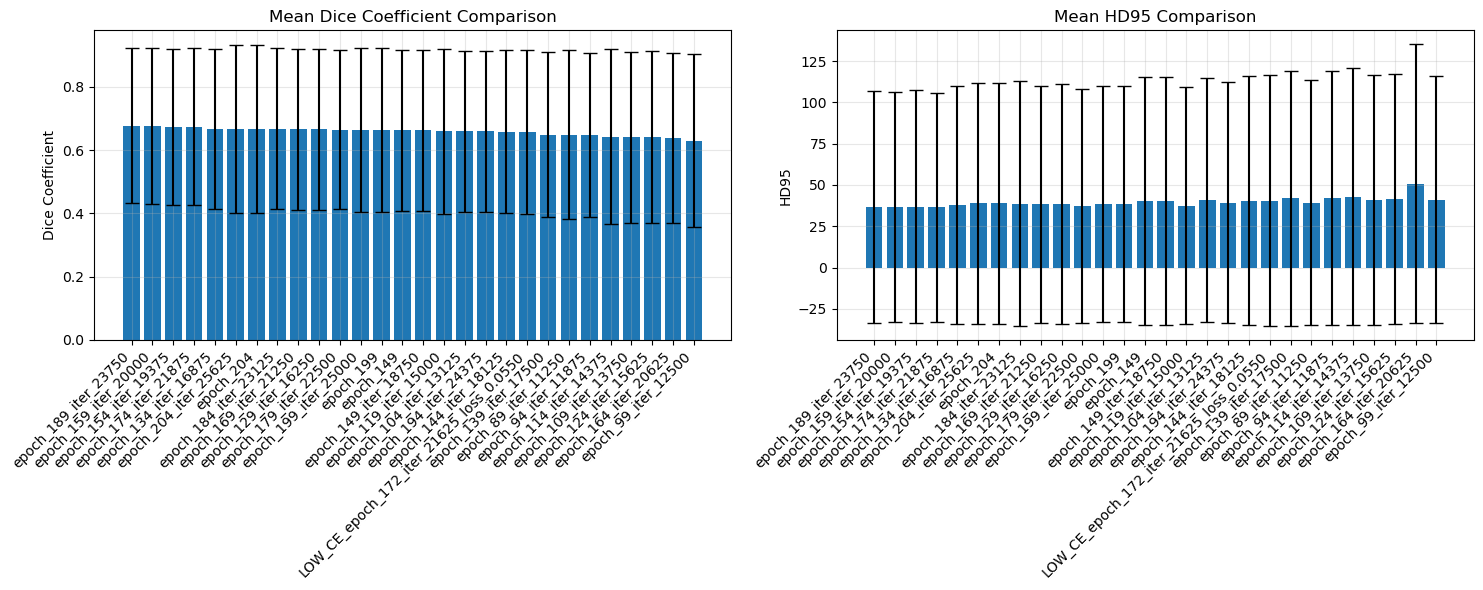


Best performing model: epoch_189_iter_23750
Mean Dice: 0.6777
Mean HD95: 36.8867


In [43]:
import glob
import os


def test_all_models_in_directory(model_directory, test_args):
    """
    Automatically test all .pth files in a directory
    
    Args:
        model_directory: Path to directory containing .pth files
        test_args: Test arguments
    """
    
    # Find all .pth files in the directory
    model_files = glob.glob(os.path.join(model_directory, "*.pth"))
    
    if not model_files:
        print(f"No .pth files found in {model_directory}")
        return {}
    
    print(f"Found {len(model_files)} model files:")
    for file in model_files:
        print(f"  - {os.path.basename(file)}")
    
    all_results = {}
    
    for model_path in model_files:
        model_name = os.path.basename(model_path).replace('.pth', '')
        print(f"\n{'='*50}")
        print(f"Testing Model: {model_name}")
        print(f"{'='*50}")
        
        # Create model
        config_vit = CONFIGS[test_args.vit_name]
        config_vit.n_classes = test_args.num_classes
        config_vit.n_skip = test_args.n_skip
        config_vit.patches.size = (test_args.vit_patches_size, test_args.vit_patches_size)
        
        if 'R50' in test_args.vit_name:
            grid_size = int(test_args.img_size / test_args.vit_patches_size)
            config_vit.patches.grid = (grid_size, grid_size)
        
        net = VisionTransformer(config_vit, img_size=test_args.img_size, 
                               num_classes=config_vit.n_classes).to(device)
        
        # Load model weights
        try:
            print(f"Loading model from: {model_path}")
            net.load_state_dict(torch.load(model_path))
            
            # Run inference
            test_results = run_inference_simple(test_args, net)
            all_results[model_name] = test_results
            
        # print Model stats
            
            print(f"\n{'='*50}")
            print(f"Results For Model: {model_name}")
            
            dice_scores = [r['dice'] for r in test_results]
            print(f"{model_name}: Mean Dice = {np.mean(dice_scores):.4f}, Std = {np.std(dice_scores):.4f}")
            print(f"{model_name}: Median Dice = {np.median(dice_scores):.4f}, Std = {np.std(dice_scores):.4f}")
            print(f"\n{'-'*50}")
            # HD95 scores
            hd95_scores = [r['hd95'] for r in test_results]
            print(f"{model_name}: Mean HD95 = {np.mean(hd95_scores):.4f}, Std = {np.std(hd95_scores):.4f}")
            print(f"{model_name}: Median HD95 = {np.median(hd95_scores):.4f}, Std = {np.std(hd95_scores):.4f}")
            print(f"{'='*50}")

            
            # Clean up GPU memory
            del net
            torch.cuda.empty_cache()
            
        except Exception as e:
            print(f"Error loading model {model_path}: {e}")
            all_results[model_name] = None
    
    return all_results

def run_inference_simple(args, model):
    """Simplified inference without saving files"""
    print("Starting inference...")
    
    # Create test dataset
    db_test = GF7Dataset(
        image_dir=args.image_dir,
        mask_dir=args.mask_dir,
        image_size=args.img_size,
        transform=None
    )
    
    testloader = DataLoader(db_test, batch_size=1, shuffle=False, num_workers=0)
    print(f"Testing on {len(db_test)} samples")
    
    model.eval()
    all_metrics = []
    
    # Maximum possible distance in a 224x224 image
    max_distance = np.sqrt(224**2 + 224**2)  # ≈ 316.8
    
    with torch.no_grad():
        for i, (image_batch, label_batch) in enumerate(tqdm(testloader, desc="Testing")):
            # Move to device
            image_batch = image_batch.to(device).float()
            label_np = label_batch.squeeze().cpu().numpy()
            
            # Forward pass
            outputs = model(image_batch)
            pred_np = torch.argmax(torch.softmax(outputs, dim=1), dim=1).squeeze().cpu().numpy()
            
            # Calculate metrics for foreground class - FIXED LOGIC
            if pred_np.sum() > 0 and label_np.sum() > 0:
                dice = metric.binary.dc(pred_np, label_np)
                hd95 = metric.binary.hd95(pred_np, label_np)
            elif pred_np.sum() > 0 and label_np.sum() == 0:
                # False positives: predicted buildings where none exist
                dice, hd95 = 0, max_distance
            elif pred_np.sum() == 0 and label_np.sum() > 0:
                # False negatives: missed buildings that should exist
                dice, hd95 = 0, max_distance
            else:
                # Both empty - perfect agreement
                dice, hd95 = 1, 0
            
            all_metrics.append({
                'filename': os.path.basename(db_test.image_paths[i]),
                'dice': dice,
                'hd95': hd95
            })
    
    return all_metrics

def compare_all_models(all_results):
    """Simple comparison of all model results"""
    import pandas as pd
    import matplotlib.pyplot as plt
    
    comparison_data = []
    
    for model_name, results in all_results.items():
        if results is not None:
            dice_scores = [r['dice'] for r in results]
            hd95_scores = [r['hd95'] for r in results]
            
            comparison_data.append({
                'Model': model_name,
                'Mean Dice': np.mean(dice_scores),
                'Std Dice': np.std(dice_scores),
                'Mean HD95': np.mean(hd95_scores),
                'Std HD95': np.std(hd95_scores),
                'Median Dice': np.median(dice_scores),
                'Median HD95': np.median(hd95_scores),
                'Max Dice': np.max(dice_scores),
                'Min Dice': np.min(dice_scores)
            })
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    
    # Sort by Mean Dice descending
    comparison_df = comparison_df.sort_values('Mean Dice', ascending=False)
    
    print("\nModel Comparison Results (Sorted by Mean Dice):")
    print("="*100)
    display(comparison_df)
    
    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Dice Coefficient comparison
    ax1.bar(range(len(comparison_df)), comparison_df['Mean Dice'], 
            yerr=comparison_df['Std Dice'], capsize=5)
    ax1.set_title('Mean Dice Coefficient Comparison')
    ax1.set_ylabel('Dice Coefficient')
    ax1.set_xticks(range(len(comparison_df)))
    ax1.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    # HD95 comparison
    ax2.bar(range(len(comparison_df)), comparison_df['Mean HD95'], 
            yerr=comparison_df['Std HD95'], capsize=5)
    ax2.set_title('Mean HD95 Comparison')
    ax2.set_ylabel('HD95')
    ax2.set_xticks(range(len(comparison_df)))
    ax2.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

model_directory = "model/TU_GF7224/TU_pretrain_R50-ViT-B_16_skip3_epo205_bs25_lr0.0001_224_s42"
test_args = args 


# Run comparison on all models in the directory
print("Testing all models in directory...")
results = test_all_models_in_directory(model_directory, test_args)
comparison = compare_all_models(results)

# Show the best performing model
if not comparison.empty:
    best_model = comparison.iloc[0]
    print(f"\nBest performing model: {best_model['Model']}")
    print(f"Mean Dice: {best_model['Mean Dice']:.4f}")
    print(f"Mean HD95: {best_model['Mean HD95']:.4f}")

In [44]:
comparison.round(2) # Round the comparison DataFrame for better readability

Model  Mean Dice  Std Dice  Mean HD95  \
18                     epoch_189_iter_23750       0.68      0.24      36.89   
12                     epoch_159_iter_20000       0.68      0.25      36.70   
11                     epoch_154_iter_19375       0.67      0.25      36.91   
15                     epoch_174_iter_21875       0.67      0.25      36.56   
6                      epoch_134_iter_16875       0.67      0.25      37.83   
23                     epoch_204_iter_25625       0.67      0.26      38.98   
22                                epoch_204       0.67      0.26      38.98   
17                     epoch_184_iter_23125       0.67      0.25      38.78   
14                     epoch_169_iter_21250       0.67      0.25      38.22   
5                      epoch_129_iter_16250       0.67      0.25      38.58   
16                     epoch_179_iter_22500       0.66      0.25      37.29   
21                     epoch_199_iter_25000       0.66      0.26      38.52   
20                                epoch_199       0.66      0.26      38.52   
9                                 epoch_149       0.66      0.25      40.45   
10                     epoch_149_iter_18750       0.66      0.25      40.45   
3                      epoch_119_iter_15000       0.66      0.26      37.57   
0                      epoch_104_iter_13125       0.66      0.25      41.06   
19                     epoch_194_iter_24375       0.66      0.26      39.32   
8                      epoch_144_iter_18125       0.66      0.26      40.60   
27  LOW_CE_epoch_172_iter_21625_loss_0.0550       0.66      0.26      40.53   
7                      epoch_139_iter_17500       0.65      0.26      41.85   
24                      epoch_89_iter_11250       0.65      0.27      39.28   
25                      epoch_94_iter_11875       0.65      0.26      42.21   
2                      epoch_114_iter_14375       0.64      0.28      42.88   
1                      epoch_109_iter_13750       0.64      0.27      41.04   
4                      epoch_124_iter_15625       0.64      0.27      41.68   
13                     epoch_164_iter_20625       0.64      0.27      50.80   
26                      epoch_99_iter_12500       0.63      0.27      41.08   

    Std HD95  Median Dice  Median HD95  Max Dice  Min Dice  
18     70.19         0.75        11.22       1.0       0.0  
12     69.60         0.75        11.31       1.0       0.0  
11     70.42         0.75        11.40       1.0       0.0  
15     69.32         0.75        11.19       1.0       0.0  
6      71.95         0.75        11.18       1.0       0.0  
23     72.94         0.75        11.91       1.0       0.0  
22     72.94         0.75        11.91       1.0       0.0  
17     73.98         0.75        11.70       1.0       0.0  
14     71.86         0.75        11.79       1.0       0.0  
5      72.66         0.75        11.70       1.0       0.0  
16     70.65         0.74        11.70       1.0       0.0  
21     71.42         0.74        12.37       1.0       0.0  
20     71.42         0.74        12.37       1.0       0.0  
9      75.12         0.75        11.70       1.0       0.0  
10     75.12         0.75        11.70       1.0       0.0  
3      71.76         0.74        12.00       1.0       0.0  
0      73.89         0.74        12.44       1.0       0.0  
19     73.10         0.74        12.35       1.0       0.0  
8      75.17         0.74        12.04       1.0       0.0  
27     75.76         0.74        12.00       1.0       0.0  
7      76.97         0.73        12.04       1.0       0.0  
24     74.09         0.73        12.04       1.0       0.0  
25     76.86         0.73        12.37       1.0       0.0  
2      77.68         0.73        12.97       1.0       0.0  
1      75.73         0.72        13.04       1.0       0.0  
4      75.78         0.73        12.68       1.0       0.0  
13     84.27         0.73        13.60       1.0       0.0  
26     74.79         0.71        13.89